#  **EDA por Disciplina** 
Este notebook apresenta uma análise exploratória detalhada da base de dados referente aos estudantes do ensino médio matriculados uma disciplina (Português ou Matemática) em duas escolas de portugal. O objetivo principal é identificar padrões e fatores que influenciam o desempenho acadêmico dos estudantes.

## Fonte dos Dados

Os dados utilizados nesta análise são provenientes do *UCI Machine Learning Repository*, especificamente do conjunto de dados "*Student Performance*". Este *dataset* contém informações sobre o desempenho acadêmico de estudantes do ensino médio em Portugal, incluindo notas em matemática e diversos fatores socioeconômicos.

**Fonte Original**: 

***UCI Machine Learning Repository - Student Performance Dataset***: 
*https://archive.ics.uci.edu/dataset/320/student+performance*

## Objetivos Gerais

A análise realizada visa:

1. Compreender o perfil dos alunos e suas características predominantes
2. Investigar fatores que influenciam o desempenho acadêmico  
3. Fornecer *insights* para intervenções educacionais baseadas em evidências

###### ajustar o path

In [1]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

# ***Matemática***

## 1. Bibliotecas, Módulos e Configurações Iniciais

In [2]:
#Importação dos Módulos e Funções Desenvolvidos

from modulos.pre_modelagem import importar_base, preparar_dados
from modulos.eda_functions import (
    plot_distribuicao_quantitativas, custom_heatmap,
    resumir_outliers, selecao_impacto_variaveis_categoricas,
    plot_boxplot_countplot, identificar_extremos_comparaveis,
    plot_top_diferencas_extremos, plot_boxplot_boxplot,
    plot_notas_faltas, aplicar_estilo_visual,
    diagnostico_impacto_variaveis_categoricas
)

from modulos.feature_selection import add_features_describe_pd,avaliacao_variacao_pontuacao_media_por_categoria


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configurações do Pandas para exibir todas as linhas e colunas no DataFrame 
# para inspeção detalhada dos dados no Jupyter Notebook

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')

In [3]:
# Variáveis Globais
#materia = "portugues" 
materia = "matematica"
#cores = 'azul' 
cores = 'verde'
#cores_reprovacao = 'laranja'
cores_reprovacao = 'vermelho'

In [4]:
#Importação da base de dados
df_o = importar_base(materia)
#importando a base de dados de treino para evitar o vazamento de dados
df_t = pd.read_csv(f'./data/dados_treino_{materia}_rs42.csv')

# 1. Visão geral e preparação dos dados

#### Conhecendo a Base - Original

In [5]:
df = df_o.copy()
#Amostra do Data Frame
df.head()

,escola,genero,idade,endereco,tamanho_familia,status_parental,escolaridade_mae,escolaridade_pai,profissao_mae,profissao_pai,motivo_escolha_escola,responsavel_legal,tempo_transporte,tempo_estudo,reprovacoes,apoio_escolar,apoio_familiar,aulas_particulares,atividades_extracurriculares,frequentou_creche,interesse_ensino_superior,acesso_internet,relacionamento_romantico,relacao_familiar,tempo_livre,frequencia_saidas,alcool_dias_uteis,alcool_fim_semana,saude,faltas,nota1,nota2,nota_final,aprovacao
0,Gabriel Pereira,Mulher,18,Urbano,Mais de 3 membros,Separados,4,4,Dona de casa,Professor(a),Curso específico,Mãe,2,2,0,Sim,Não,Não,Não,Sim,Sim,Não,Não,4,3,4,1,1,3,6,5,6,6,Reprovado
1,Gabriel Pereira,Mulher,17,Urbano,Mais de 3 membros,Juntos,1,1,Dona de casa,Outra profissão,Curso específico,Pai,1,2,0,Não,Sim,Não,Não,Não,Sim,Sim,Não,5,3,3,1,1,3,4,5,5,6,Reprovado
2,Gabriel Pereira,Mulher,15,Urbano,3 membros ou menos,Juntos,1,1,Dona de casa,Outra profissão,Outro motivo,Mãe,1,2,3,Sim,Não,Sim,Não,Sim,Sim,Sim,Não,4,3,2,2,3,3,10,7,8,10,Aprovado
3,Gabriel Pereira,Mulher,15,Urbano,Mais de 3 membros,Juntos,4,2,Área da saúde,Serviços,Próximo de casa,Mãe,1,3,0,Não,Sim,Sim,Sim,Sim,Sim,Sim,Sim,3,2,2,1,1,5,2,15,14,15,Aprovado
4,Gabriel Pereira,Mulher,16,Urbano,Mais de 3 membros,Juntos,3,3,Outra profissão,Outra profissão,Próximo de casa,Pai,1,2,0,Não,Sim,Sim,Não,Sim,Sim,Não,Não,4,3,2,1,2,5,4,6,10,10,Aprovado


In [6]:
df.shape

(395, 34)

In [7]:
df_t.shape

(276, 34)

In [8]:
#Verificando se as colunas são as mesmas
df.columns.tolist() == df_t.columns.tolist()


True

In [9]:
#Checagem de duplicatas
df_t.duplicated().sum()==df.duplicated().sum()==0

True

#### Variáveis Locais

###### Agrupamento de Estatísticas

In [10]:
group_stats = {
    "Tendência Central": ["Média", "Mediana (50%)", "Moda"],
    "Dispersão": ["Desvio Padrão", "Coeficiente de Variação (CV)"],
    "Distribuição / Posição": ["Mínimo", "1º Quartil (25%)", "Mediana (50%)", "3º Quartil (75%)", "Máximo"],
    "Normalidade": ["Shapiro-Wilk (p-valor)"],
}


###### Notas

In [11]:
notas = ['nota1', 'nota2', 'nota_final']

**Categorização de Atributos**

- As variáveis foram categorizadas em três grupos principais:

    >    1. **Variáveis Categóricas Nominais**: Atributos qualitativos sem ordem natural
    >    2. **Variáveis Categóricas Ordinais**: Atributos qualitativos com ordem natural
    >    3. **Variáveis Numéricas**: Atributos quantitativos discretos

In [12]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais

variaveis_quantitativas = [
    'idade', 
    'faltas', 
    'nota1', 
    'nota2', 
    'nota_final'
]

In [13]:
df = df_t.copy()



# 2. Análise de Atributos Quantitativos e Outliers

Nesta seção, investiga-se as variáveis quantitativas presentes na base de dados da disciplina de Matemática, com foco em suas distribuições, medidas centrais, dispersão e possíveis valores atípicos (*outliers*). A análise explora ainda a normalidade dos dados, as relações entre variáveis contínuas, e a forma como essas características se associam ao desempenho dos estudantes.

Além disso, é explorado como atributos como notas e faltas se comportam entre os grupos de aprovação, e se existem padrões relevantes ao considerar a idade ou faixas etárias.

**Obtenção do Resumo Estatístico**

In [14]:
desc_q = add_features_describe_pd(df, variaveis_quantitativas)

Tamanho da amostra (numérico): 276.0


## 2.1 Resumo de Estatísticas Descritivas

Apresenta-se um panorama geral das variáveis quantitativas por meio de estatísticas descritivas clássicas.

**Objetivos:**  
- Compreender o comportamento de medidas centrais e de dispersão dos dados;  
- Identificar assimetrias e possíveis anomalias;  
- Avaliar a adequação de técnicas estatísticas nas etapas seguintes.




### 2.1.1 Medidas de Tendência Central e Dispersão

Examinam-se métricas como média, mediana, desvio padrão, valores extremos e amplitude interquartílica, com finalidade de caracterizar a distribuição das variáveis e suas variações internas.

In [15]:
mtcp = desc_q[group_stats["Tendência Central"]+group_stats["Dispersão"]].round(4)
mtcp

,Média,Mediana (50%),Moda,Desvio Padrão,Coeficiente de Variação (CV)
Variável,,,,,
idade,16.6703,17.0,16,1.2402,0.074
faltas,5.8116,3.0,0,7.8236,1.346
nota1,10.8804,11.0,10,3.3178,0.305
nota2,10.7645,11.0,9,3.7113,0.345
nota_final,10.4275,11.0,10,4.5764,0.439


#### Oportunidade de investigação: Moda e notas mínimas de aprovação

In [16]:
len(df[df['nota_final']==11])/len(df['nota_final'])

0.10869565217391304

In [17]:
len(df[df['nota_final'].isin([10, 11])]) / len(df['nota_final'])

0.25


### 2.1.2 Distribuições, Normalidade e Presença de Outliers

Analisa-se a forma das distribuições, com apoio de visualizações gráficas e testes de normalidade. Identificam-se potenciais outliers, cuja presença pode distorcer medidas e impactar análises posteriores.


In [18]:
stats_mddn =desc_q[group_stats["Distribuição / Posição"]+group_stats["Normalidade"]]
stats_mddn

,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Shapiro-Wilk (p-valor)
Variável,,,,,,
idade,15.0,16.0,17.0,18.0,21.0,1.16e-11
faltas,0.0,0.0,3.0,8.0,75.0,7.18e-22
nota1,3.0,8.0,11.0,13.0,19.0,1.03e-04
nota2,0.0,9.0,11.0,13.0,19.0,2.24e-05
nota_final,0.0,8.0,11.0,13.0,19.0,3.75e-10


##### **Presença de outliers**

> Os outliers foram identificados usando o método do Intervalo Interquartil (IQR):
>   - Limite Inferior = Q1 - 1.5 * IQR
>   - Limite Superior = Q3 + 1.5 * IQR

In [19]:
#resumir outliers 

resumo_outliers_numerico = resumir_outliers(df = df[variaveis_quantitativas])


,Q1 (1º Quartil),Q3 (3º Quartil),Limite Inferior (L1),Limite Superior (L3),Outliers Totais,Outliers < L1,Outliers > L3
nota_final,8.0,13.0,0.5,20.5,26,26,0
faltas,0.0,8.0,-12.0,20.0,12,0,12
nota2,9.0,13.0,3.0,19.0,8,8,0
idade,16.0,18.0,13.0,21.0,0,0,0
nota1,8.0,13.0,0.5,20.5,0,0,0


#### 2.1.2.1 Perfil dos Outliers



##### **Levantamento de recursos para a análise**

In [20]:
variaveis_de_interesse = variaveis_categoricas + ['idade']

In [21]:
# Lista de variáveis com outliers
outliers_index_list = resumo_outliers_numerico.index.tolist()

In [22]:
limites_outliers = {}

for var in outliers_index_list:
    out_baixo = resumo_outliers_numerico.loc[var, 'Outliers < L1']
    out_alto = resumo_outliers_numerico.loc[var, 'Outliers > L3']

    if out_baixo > 0 or out_alto > 0:
        limites_outliers[var] = {
            'lim_inf': float(resumo_outliers_numerico.loc[var, 'Limite Inferior (L1)']),
            'lim_sup': float(resumo_outliers_numerico.loc[var, 'Limite Superior (L3)'])
        }


In [23]:
limites_outliers

{'nota_final': {'lim_inf': 0.5, 'lim_sup': 20.5},
 'faltas': {'lim_inf': -12.0, 'lim_sup': 20.0},
 'nota2': {'lim_inf': 3.0, 'lim_sup': 19.0}}

**Notas**

##### **Perfil Outiliers - Nota2**

###### **Nota 2 - Limite Inferior**

In [24]:
var = 'nota2'

perfil = df[df[var] < limites_outliers[var]['lim_inf']]
      
perfil = add_features_describe_pd(df= perfil
                                ,colunas=variaveis_de_interesse,
                                estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 8


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,1,Gabriel Pereira,8,100.0,12.5
genero,2,Mulher,5,62.5,25.0
endereco,2,Urbano,6,75.0,25.0
status_parental,2,Juntos,7,87.5,25.0
profissao_mae,2,Outra profissão,5,62.5,25.0
profissao_pai,4,Outra profissão,5,62.5,50.0
motivo_escolha_escola,3,Curso específico,4,50.0,37.5
responsavel_legal,3,Mãe,5,62.5,37.5
apoio_escolar,1,Não,8,100.0,12.5


##### **Perfil Outiliers - Nota Final**

###### **Nota Final - Limite Inferior**

In [25]:
var = 'nota_final'
perfil = df[df[var] < limites_outliers[var]['lim_inf']]

print(perfil.value_counts())

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

escola                genero  idade  endereco  tamanho_familia     status_parental  escolaridade_mae  escolaridade_pai  profissao_mae    profissao_pai    motivo_escolha_escola  responsavel_legal  tempo_transporte  tempo_estudo  reprovacoes  apoio_escolar  apoio_familiar  aulas_particulares  atividades_extracurriculares  frequentou_creche  interesse_ensino_superior  acesso_internet  relacionamento_romantico  relacao_familiar  tempo_livre  frequencia_saidas  alcool_dias_uteis  alcool_fim_semana  saude  faltas  nota1  nota2  nota_final  aprovacao
Gabriel Pereira       Homem   15     Urbano    Mais de 3 membros   Juntos           4                 3                 Professor(a)     Serviços         Curso específico       Pai                2                 4             0            Sim            Sim             Não                 Não                           Sim                Sim                        Sim              Não                       2                 2            2       

,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,23,88.461538,7.692308
genero,2,Mulher,17,65.384615,7.692308
endereco,2,Urbano,22,84.615385,7.692308
status_parental,2,Juntos,25,96.153846,7.692308
profissao_mae,5,Outra profissão,12,46.153846,19.230769
profissao_pai,4,Outra profissão,14,53.846154,15.384615
motivo_escolha_escola,3,Curso específico,12,46.153846,11.538462
responsavel_legal,3,Mãe,15,57.692308,11.538462
apoio_escolar,2,Não,25,96.153846,7.692308


**Faltas**

##### **Perfil Outiliers - Faltas**

###### **Faltas - Limite Superior**

In [26]:
var = 'faltas'
perfil = df[df[var] > limites_outliers[var]['lim_sup']]

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 12


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,1,Gabriel Pereira,12,100.0,8.333333
genero,2,Mulher,9,75.0,16.666667
endereco,2,Urbano,11,91.666667,16.666667
status_parental,2,Juntos,9,75.0,16.666667
profissao_mae,4,Serviços,6,50.0,33.333333
profissao_pai,3,Outra profissão,6,50.0,25.0
motivo_escolha_escola,3,Próximo de casa,8,66.666667,25.0
responsavel_legal,3,Mãe,9,75.0,25.0
apoio_escolar,2,Não,11,91.666667,16.666667


## Principais Padrões de Desempenho e Outliers

As análises demonstraram padrões consistentes de desempenho entre os alunos, com evidências claras de que fatores sociofamiliares, comportamentais e estruturais impactam diretamente as notas e o número de faltas.

**Notas muito baixas (nota1, nota2, nota_final) foram associadas a:**

- Forte presença da escola Mousinho da Silveira;

- Baixa escolaridade dos responsáveis e predominância de profissões menos qualificadas;

- Ausência de apoio escolar, familiar e de aulas particulares;

- Alta frequência de consumo de álcool durante a semana e tempo de transporte elevado;

- Tempo de estudo reduzido e maior prevalência de reprovações anteriores.

**Notas muito altas (nota1 > 15, nota2 > 17) foram observadas em perfis com:**

- Estrutura familiar mais estável (pais juntos, apoio familiar presente);

- Alta escolaridade dos pais e dedicação consistente aos estudos;

- Acesso à internet, interesse declarado no ensino superior e poucas ou nenhuma reprovação.

**Notas finais igual a zero ou muito baixas (< 4)** seguiram padrões similares, reforçando a existência 
  de um subconjunto de alunos com múltiplos indicadores de risco educacional e social.

**Faltas excessivas (> 20)** foram associadas a:

- Perfil aparentemente escolarizado (escola Gabriel Pereira, pais com maior escolaridade);

- Indícios de desorganização da rotina, tempo livre elevado e baixo envolvimento em atividades extracurriculares;

- Prevalência de motivos pragmáticos (como “próximo de casa”) para a escolha da escola;

Apesar disso, **92% dos alunos com faltas excessivas** afirmaram desejar cursar o ensino superior, indicando uma desconexão entre aspiração e prática escolar.


### 2.1.3 Visualizações

Exploram-se, de forma visual, os casos extremos identificados.


**Distribuição das Notas**

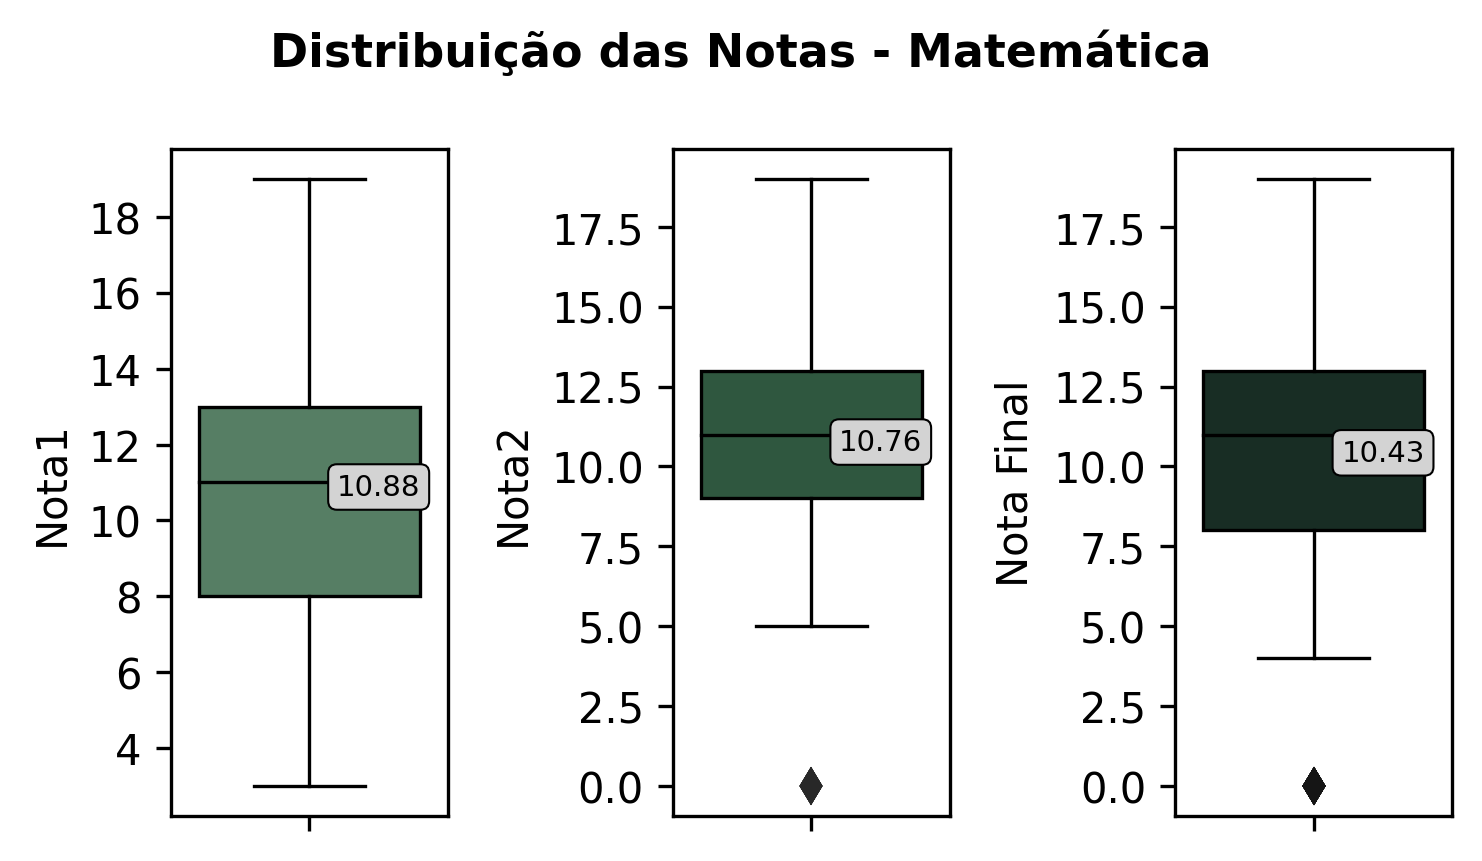

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:ylabel='Nota1'>, <AxesSubplot:ylabel='Nota2'>,
        <AxesSubplot:ylabel='Nota Final'>], dtype=object))

In [27]:
plot_distribuicao_quantitativas(df,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia)
                                

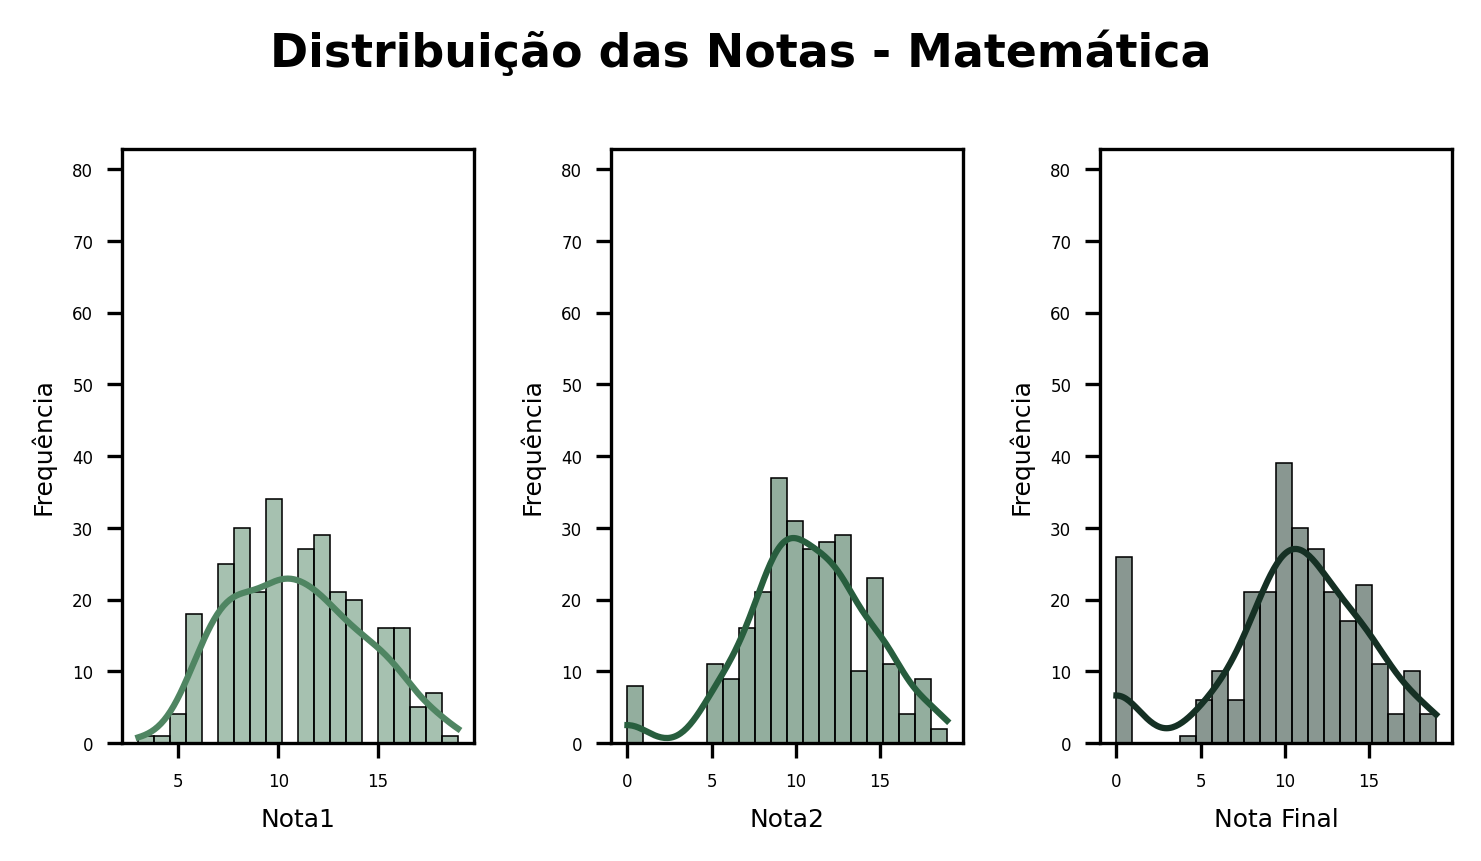

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='Nota1', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota2', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota Final', ylabel='Frequência'>],
       dtype=object))

In [28]:
plot_distribuicao_quantitativas(df,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia,
                                modo = 'hist')
                                

**Distribuição de Idade e Faltas**

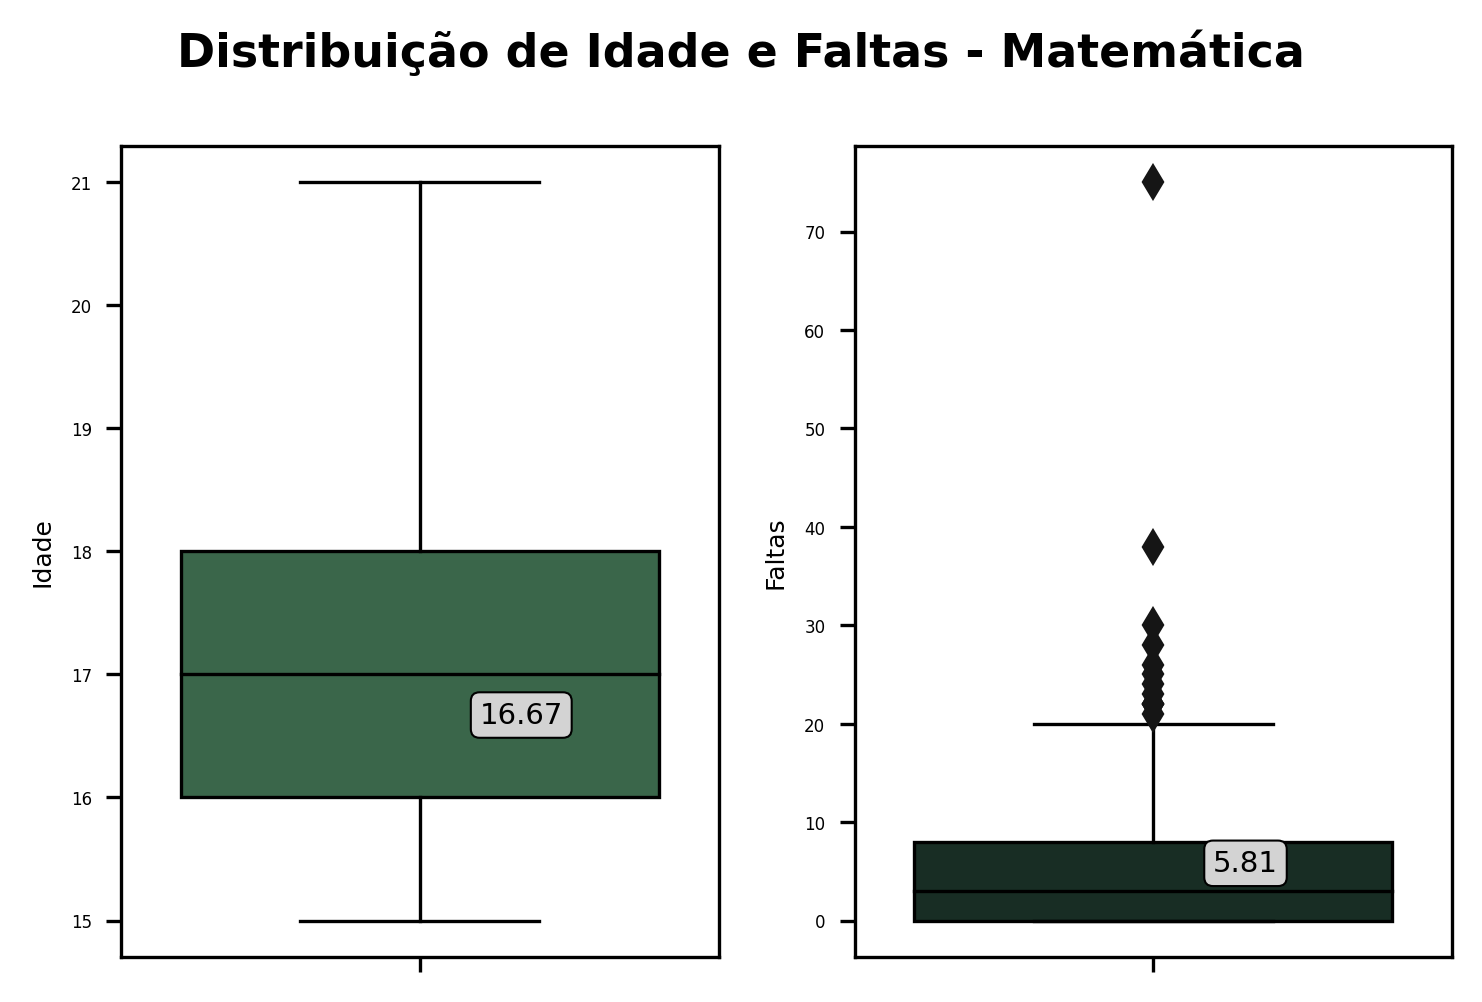

(<Figure size 1512x1008 with 2 Axes>,
 array([<AxesSubplot:ylabel='Idade'>, <AxesSubplot:ylabel='Faltas'>],
       dtype=object))

In [29]:
plot_distribuicao_quantitativas(df,
                                colunas=['idade','faltas'],
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia)

### 2.1.4 Síntese Analítica dos Destaques

> ### 2.1.4 Síntese Analítica dos Destaques
>
> Apresentam-se a seguir os principais achados obtidos a partir da análise estatística descritiva e exploratória das variáveis quantitativas da disciplina de Matemática:
>
> - **Notas (Nota1, Nota2, Nota Final)**:
>   - Distribuições assimétricas à direita, com cauda mais acentuada para notas baixas;
>   - As médias mantêm-se próximas (Nota1: 10,88; Nota2: 10,76; Nota Final: 10,43), com leve decréscimo na etapa final;
>   - Crescimento do coeficiente de variação ao longo das avaliações (Nota1: 0,31 → Nota Final: 0,44), indicando maior dispersão nas notas finais;
>   - Resultados do teste de Shapiro-Wilk (p < 0,001) rejeitam a hipótese de normalidade para todas as notas;
>   - Foram identificados outliers em Nota2 (n=8) e Nota Final (n=26), concentrados em valores muito baixos, incluindo casos com nota zero.
>
> - **Faltas**:
>   - Mediana de 3 faltas e moda igual a 0, refletindo uma concentração de alunos com baixa ausência;
>   - Distribuição fortemente assimétrica à direita, com valores extremos atingindo 75 faltas;
>   - Coeficiente de variação elevado (CV ≈ 1,35), sugerindo alta dispersão relativa;
>   - 12 outliers superiores identificados, todos acima de 20 faltas.
>
> - **Idade**:
>   - Distribuição concentrada entre 15 e 18 anos, com mediana de 17 e moda 16;
>   - Ausência de outliers, mesmo com um caso máximo de 21 anos;
>   - Baixa variabilidade (CV ≈ 0,07), indicando homogeneidade do grupo amostral.
>
> - **Considerações gerais**:
>   - A ausência de normalidade nas distribuições e a presença de outliers em variáveis-chave justificam a adoção de métodos estatísticos não paramétricos e técnicas robustas;
>   - A dispersão nas notas finais e o padrão assimétrico das faltas sugerem a existência de subgrupos com comportamentos escolares distintos, inclusive perfis de alto risco de reprovação.
>
> - **Distribuição das notas e a Moda**:
>   - A moda da `nota_final` é 10, representando a categoria com maior frequência;
>   - Mais de 48% dos estudantes concentram-se entre 10 e 11 pontos, próximo ao limiar de aprovação;
>   - Esse padrão reforça a importância de analisar os fatores que levam os alunos a permanecerem na zona de aprovação mínima, contribuindo para o delineamento de políticas de suporte pedagógico.



## 2.2 Análises Bivariadas Quantitativas

Nesta etapa, investigam-se as relações entre pares de variáveis quantitativas, com o objetivo de identificar padrões de associação entre atributos como faltas, idade e notas escolares. 

### 2.2.1 Análise das Notas por Grupo de Aprovação

Essa comparação é útil para caracterizar os perfis de desempenho ao longo das etapas avaliativas e pode revelar trajetórias de recuperação, estabilidade ou declínio.


In [30]:
df_aprovados = df[df['nota_final'] >= 10]
df_reprovados = df[df['nota_final'] < 10]
print(f' contagem:\n aprovados: {df_aprovados.shape[0]}, reprovados: {df_reprovados.shape[0]}')
print(f' porcentagem:\n aprovados: {df_aprovados.shape[0]/df.shape[0]*100:.2f}%, reprovados: {df_reprovados.shape[0]/df.shape[0]*100:.2f}%')

 contagem:
 aprovados: 185, reprovados: 91
 porcentagem:
 aprovados: 67.03%, reprovados: 32.97%


In [31]:
df_ap_descricao = add_features_describe_pd(df_aprovados, variaveis_quantitativas)
df_re_descricao = add_features_describe_pd(df_reprovados, variaveis_quantitativas)

Tamanho da amostra (numérico): 185.0
Tamanho da amostra (numérico): 91.0


##### **Resumos Estatísticos**

**Aprovados**

In [32]:
mtcp = df_ap_descricao[group_stats["Tendência Central"]+group_stats["Dispersão"]].round(4)
mtcp

,Média,Mediana (50%),Moda,Desvio Padrão,Coeficiente de Variação (CV)
Variável,,,,,
idade,16.5243,16.0,16,1.1613,0.070
faltas,5.1676,3.0,0,5.7530,1.113
nota1,12.4216,12.0,12,2.7811,0.224
nota2,12.6378,12.0,13,2.5588,0.202
nota_final,12.8919,12.0,10,2.5085,0.195


In [33]:
stats_mddn =df_ap_descricao[group_stats["Distribuição / Posição"]+group_stats["Normalidade"]]
stats_mddn

,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Shapiro-Wilk (p-valor)
Variável,,,,,,
idade,15.0,16.0,16.0,17.0,19.0,6.63e-10
faltas,0.0,1.0,3.0,8.0,25.0,8.84e-14
nota1,6.0,10.0,12.0,14.0,19.0,8.40e-03
nota2,8.0,11.0,12.0,15.0,19.0,2.03e-05
nota_final,10.0,11.0,12.0,15.0,19.0,2.22e-09


In [34]:
resumo_outliers_ap = resumir_outliers(df = df_aprovados[variaveis_quantitativas])

,Q1 (1º Quartil),Q3 (3º Quartil),Limite Inferior (L1),Limite Superior (L3),Outliers Totais,Outliers < L1,Outliers > L3
idade,16.0,17.0,14.5,18.5,9,0,9
faltas,1.0,8.0,-9.5,18.5,8,0,8
nota1,10.0,14.0,4.0,20.0,0,0,0
nota2,11.0,15.0,5.0,21.0,0,0,0
nota_final,11.0,15.0,5.0,21.0,0,0,0


##### **Oportunidade de Investigação - Faltas elevadas entre aprovados**

In [35]:
add_features_describe_pd(df_aprovados[df_aprovados['faltas']>19],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 7.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,17.428571,1.272418,16.0,16.5,17.0,18.5,19.0,16,2.15e-01,0.073
faltas,22.142857,1.951800,20.0,20.5,22.0,23.5,25.0,20,5.49e-01,0.088
nota1,13.714286,3.592320,7.0,13.0,13.0,16.0,18.0,13,3.32e-01,0.262
nota2,13.571429,3.359422,10.0,11.0,13.0,16.0,18.0,10,2.00e-01,0.248
nota_final,13.714286,3.039424,11.0,11.5,13.0,15.5,18.0,11,3.38e-02,0.222


In [36]:
add_features_describe_pd(df[df['faltas']>19],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 15.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,17.333333,1.175139,15.0,17.0,17.0,18.0,19.0,17,1.75e-01,0.068
faltas,27.733333,13.925653,20.0,21.5,23.0,27.0,75.0,20,1.11e-05,0.502
nota1,10.866667,3.758166,6.0,8.0,10.0,13.0,18.0,13,1.98e-01,0.346
nota2,10.533333,3.795988,6.0,8.5,9.0,12.5,18.0,9,5.88e-02,0.360
nota_final,10.466667,3.925497,4.0,8.0,9.0,12.5,18.0,8,2.80e-01,0.375


In [37]:
add_features_describe_pd(df_aprovados[df_aprovados['faltas']<=19],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 178.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,16.488764,1.146051,15.0,16.0,16.0,17.0,19.0,16,7.79e-10,0.070
faltas,4.500000,4.736265,0.0,0.0,2.0,6.0,19.0,0,1.65e-12,1.053
nota1,12.370787,2.744824,6.0,10.0,12.0,14.0,19.0,12,8.33e-03,0.222
nota2,12.601124,2.527454,8.0,11.0,12.0,15.0,19.0,13,4.99e-05,0.201
nota_final,12.859551,2.490081,10.0,11.0,12.0,15.0,19.0,10,4.09e-09,0.194


In [38]:
add_features_describe_pd(df[df['faltas']<=19],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 261.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,16.632184,1.235204,15.0,16.0,17.0,18.0,21.0,16,1.66e-11,0.074
faltas,4.551724,4.997904,0.0,0.0,2.0,8.0,19.0,0,6.90e-16,1.098
nota1,10.881226,3.298786,3.0,8.0,11.0,13.0,19.0,10,2.94e-04,0.303
nota2,10.777778,3.713339,0.0,9.0,11.0,13.0,19.0,9,2.04e-05,0.345
nota_final,10.425287,4.617606,0.0,9.0,11.0,14.0,19.0,10,2.48e-10,0.443


**Reprovados**

In [39]:
mtcp = df_re_descricao[group_stats["Tendência Central"]+group_stats["Dispersão"]].round(4)
mtcp

,Média,Mediana (50%),Moda,Desvio Padrão,Coeficiente de Variação (CV)
Variável,,,,,
idade,16.9670,17.0,17,1.3454,0.079
faltas,7.1209,4.0,0,10.8062,1.518
nota1,7.7473,8.0,7,1.7359,0.224
nota2,6.9560,8.0,9,2.6116,0.375
nota_final,5.4176,7.0,0,3.6425,0.672


In [40]:
stats_mddn =df_re_descricao[group_stats["Distribuição / Posição"]+group_stats["Normalidade"]]
stats_mddn

,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Shapiro-Wilk (p-valor)
Variável,,,,,,
idade,15.0,16.0,17.0,18.0,21.0,8.54e-05
faltas,0.0,0.0,4.0,10.5,75.0,3.69e-13
nota1,3.0,6.5,8.0,9.0,12.0,7.91e-03
nota2,0.0,6.0,8.0,9.0,11.0,1.91e-09
nota_final,0.0,0.0,7.0,8.0,9.0,1.30e-10


In [41]:
#resumir outliers 
resumo_outliers_re = resumir_outliers(df = df_reprovados[variaveis_quantitativas])

,Q1 (1º Quartil),Q3 (3º Quartil),Limite Inferior (L1),Limite Superior (L3),Outliers Totais,Outliers < L1,Outliers > L3
nota2,6.0,9.0,1.50,13.50,8,8,0
faltas,0.0,10.5,-15.75,26.25,4,0,4
idade,16.0,18.0,13.00,21.00,0,0,0
nota1,6.5,9.0,2.75,12.75,0,0,0
nota_final,0.0,8.0,-12.00,20.00,0,0,0


##### **Visualições: Distribuição das Notas**

**Aprovados**

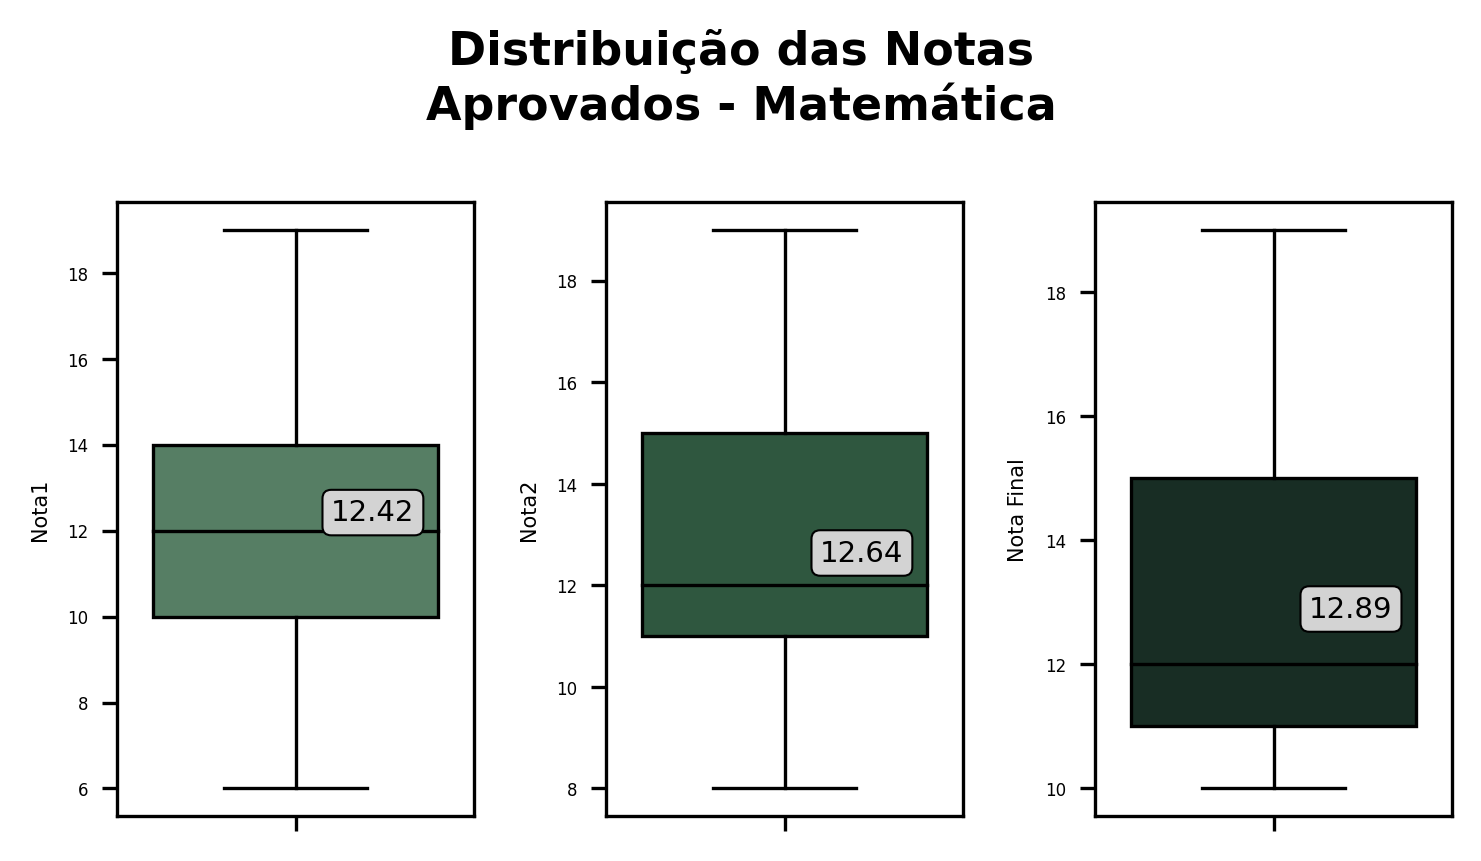

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:ylabel='Nota1'>, <AxesSubplot:ylabel='Nota2'>,
        <AxesSubplot:ylabel='Nota Final'>], dtype=object))

In [42]:
plot_distribuicao_quantitativas(df_aprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia,
                                titulo = 'Distribuição das Notas\nAprovados')
                                

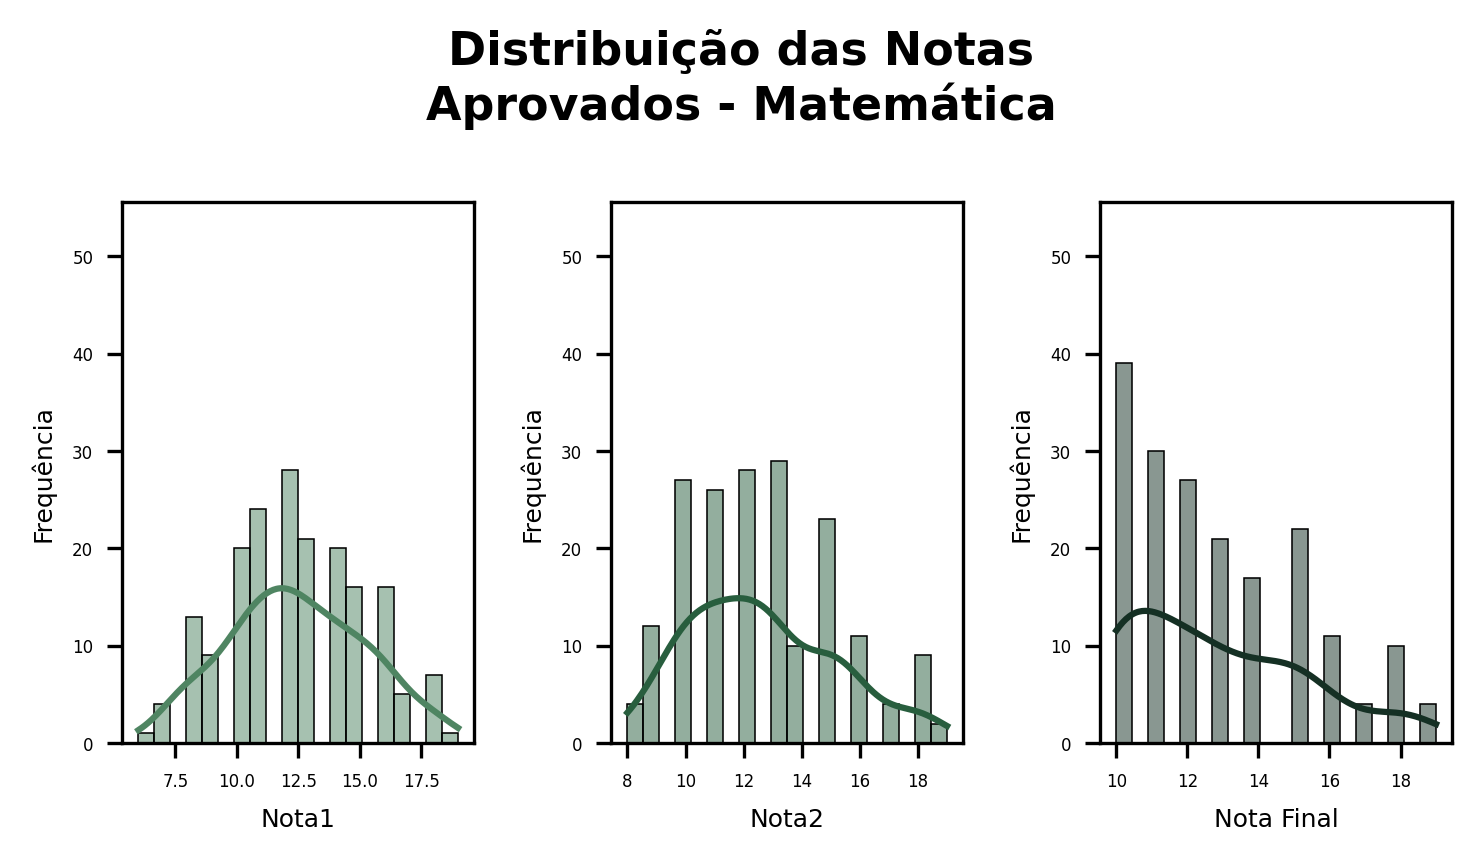

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='Nota1', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota2', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota Final', ylabel='Frequência'>],
       dtype=object))

In [43]:
plot_distribuicao_quantitativas(df_aprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia,
                                modo = 'hist',
                                titulo = 'Distribuição das Notas\nAprovados')
                                

**Reprovados**

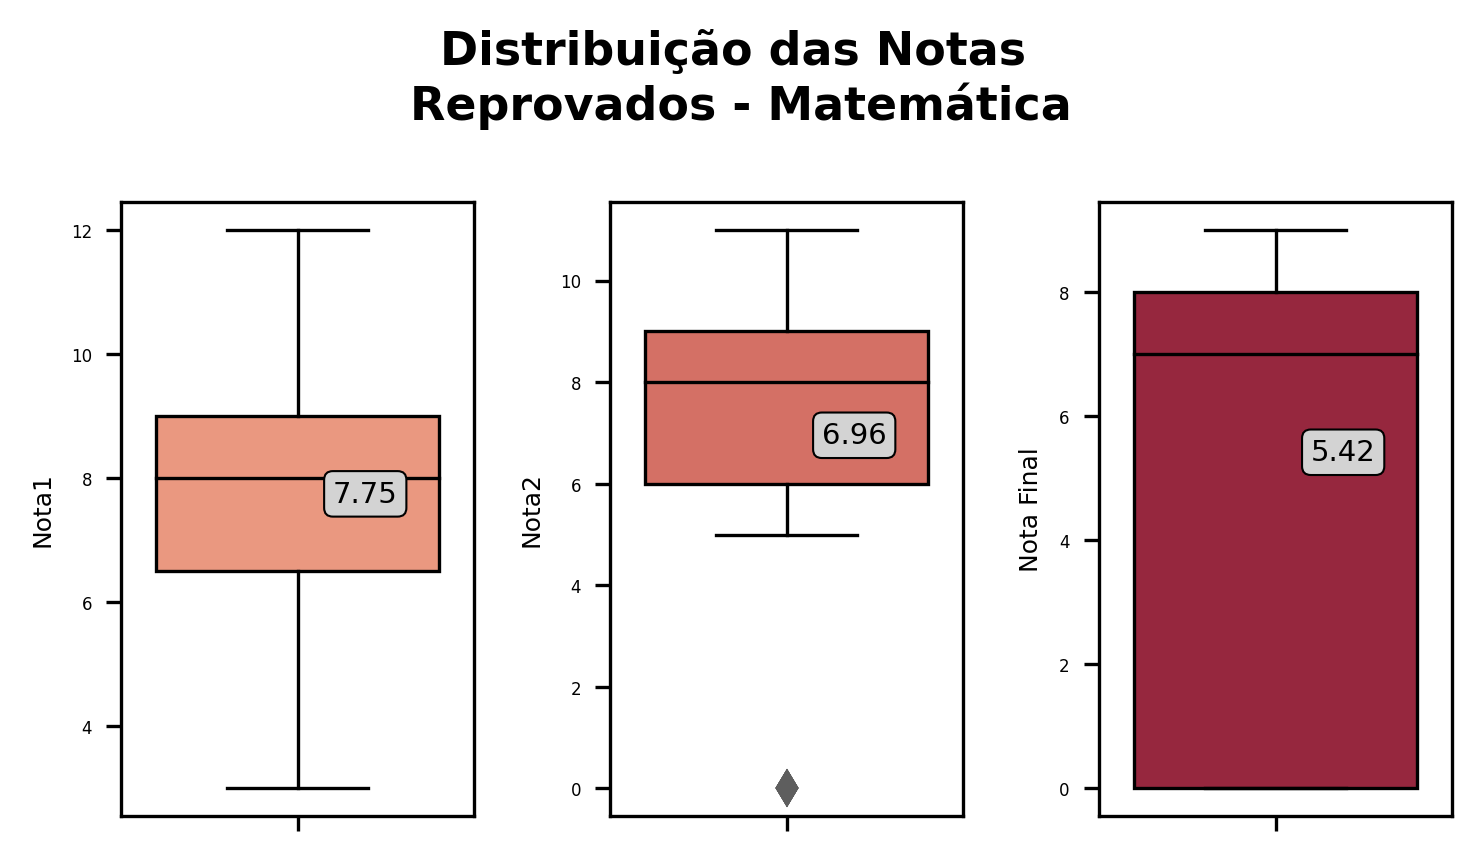

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:ylabel='Nota1'>, <AxesSubplot:ylabel='Nota2'>,
        <AxesSubplot:ylabel='Nota Final'>], dtype=object))

In [44]:
plot_distribuicao_quantitativas(df_reprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores_reprovacao,
                                materia=materia,
                                titulo = 'Distribuição das Notas \nReprovados')
                                

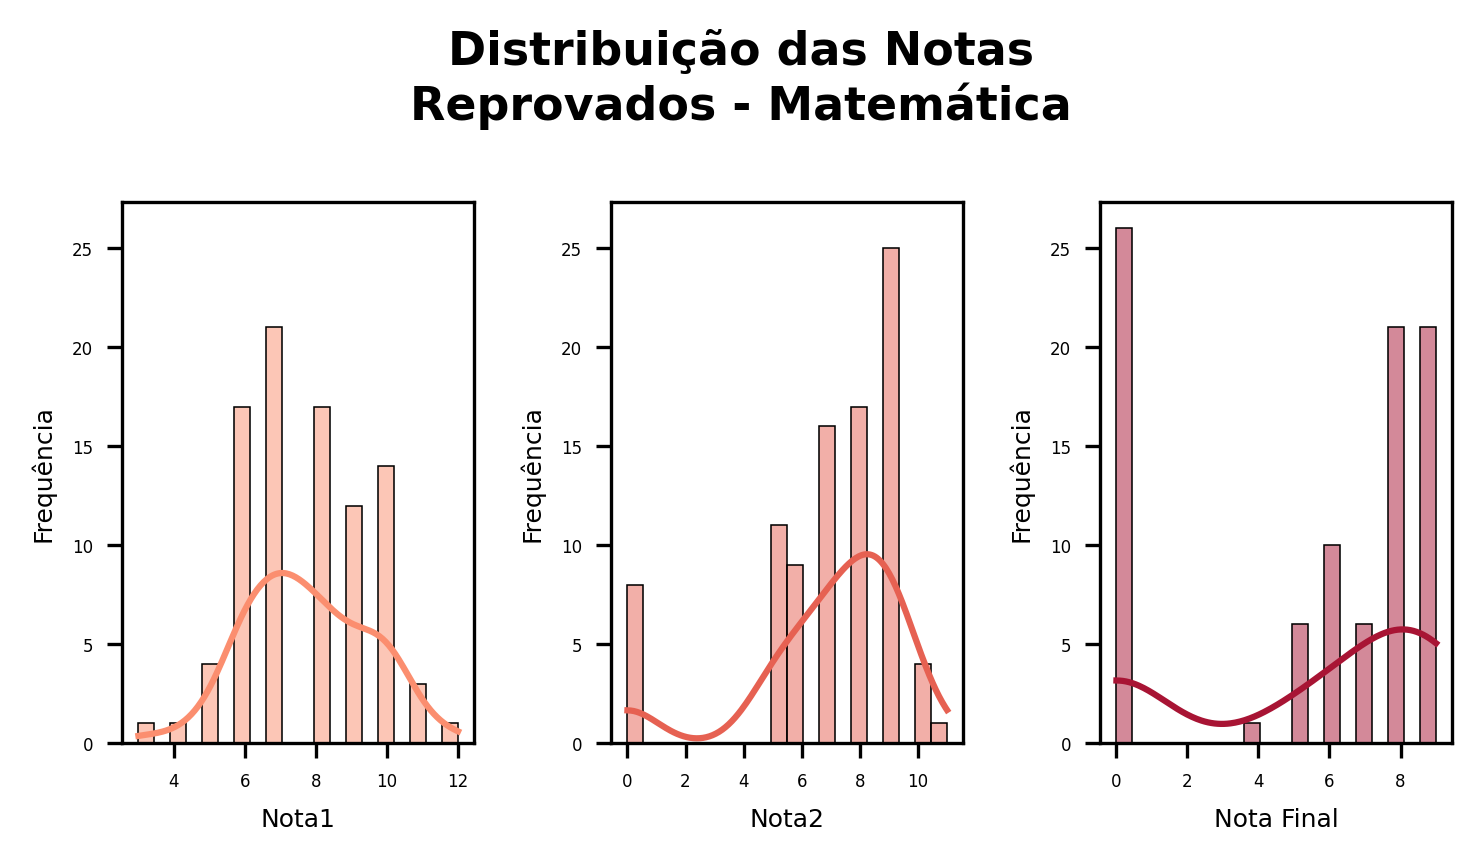

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='Nota1', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota2', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota Final', ylabel='Frequência'>],
       dtype=object))

In [45]:
plot_distribuicao_quantitativas(df_reprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores_reprovacao,
                                materia=materia,
                                modo = 'hist',
                                titulo = 'Distribuição das Notas\nReprovados')
                                

### 2.2.2 Correlações e Relações Entre Variáveis Quantitativas

Nesta subseção, investiga-se a força e direção das associações entre pares de variáveis quantitativas por meio da correlação de Spearman, adequada à natureza não normal dos dados.

In [46]:
corr_quant = df[variaveis_quantitativas].corr(method= 'spearman')


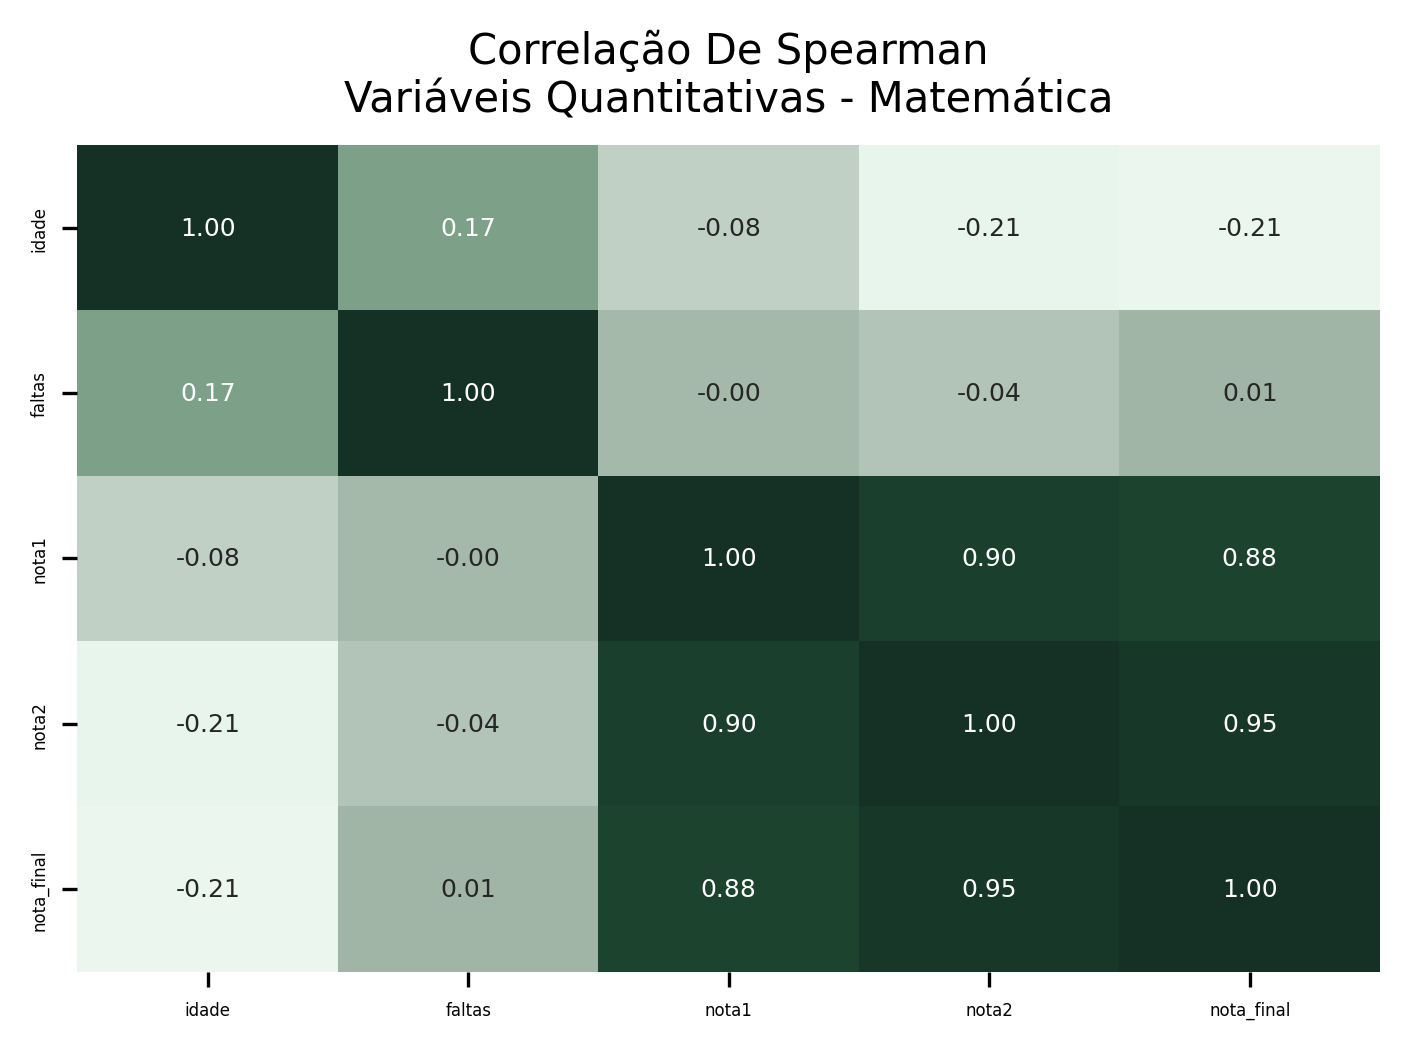

In [47]:
custom_heatmap(matriz_corr = corr_quant,
               cores = cores,
               n_arq ='heatmap_qualitativas',
               titulo = 'Correlação de Spearman \n Variáveis Quantitativas' ,
               disciplina=materia)

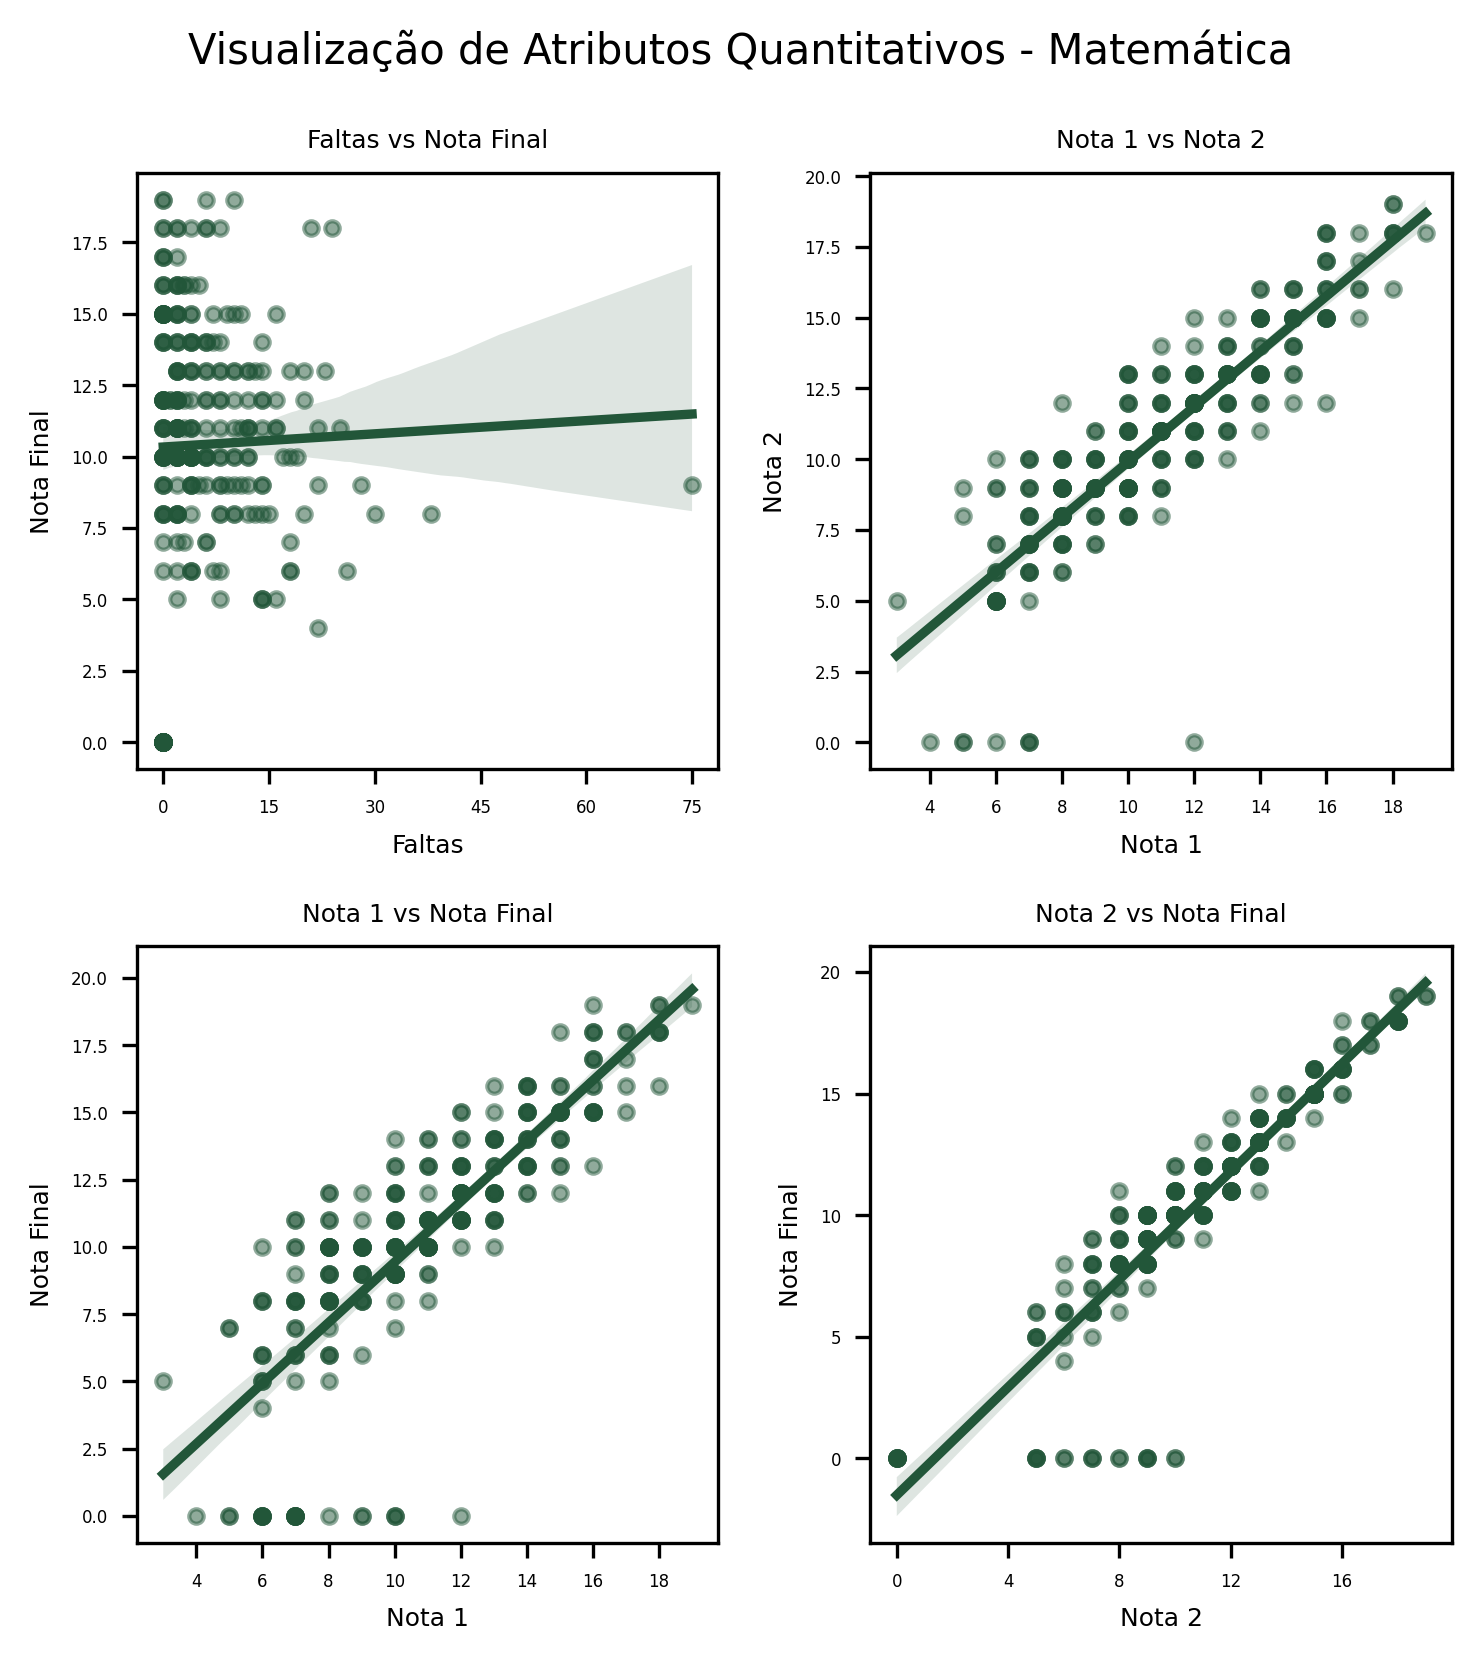

In [48]:
plot_notas_faltas(df,cor = cores, dir = 'relacao_bivariada' , mat=materia,)

### 2.2.3 Influência das Faltas no Desempenho Escolar

A análise busca responder se há evidências de que o aumento de faltas esteja associado à queda no desempenho, ou se há casos em que essa relação não se verifica — sugerindo perfis de alunos resilientes.


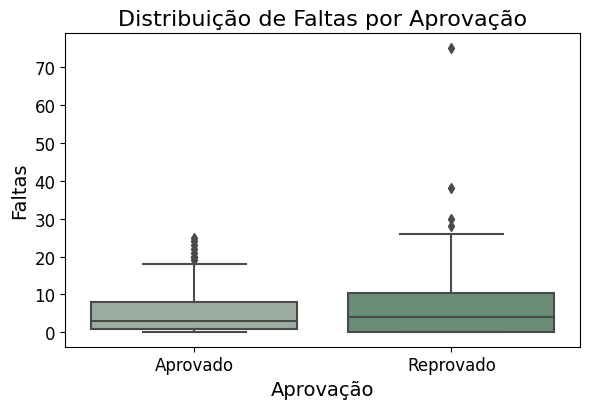

In [49]:
# Configurações do Seaborn

fig, ax = plt.subplots(figsize=(6, 4.2))
ax = sns.boxplot(x='aprovacao',y='faltas', data=df, palette=aplicar_estilo_visual(cores))
ax.set_title('Distribuição de Faltas por Aprovação', fontsize=16)
ax.set_xlabel('Aprovação', fontsize=14)
ax.set_ylabel('Faltas', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Criação de Grupos semânticos baseados em faixa de ausência*** 

| **Faixa de Faltas** | **Critério** | **Interpretação**   |
| ----- | --------------- | ------------------- |
| **0–8**         | até o Q3     | Frequência regular ou ausência leve      |
| **9–19**        | acima do Q3, mas dentro do limite de outliers | Ausência moderada   |
| **>19**         | além do limite superior de outliers           | Ausência elevada / comportamento extremo |


###### **As faixas foram definidas com base na distribuição empírica das faltas, considerando a posição dos quartis e o critério de outliers (Q3 + 1,5×IQR).*


In [50]:
bins = [-1, 8, 19, df['faltas'].max()]
labels = ['Frequência regular ou leve', 'Ausência moderada', 'Ausência elevada']

df['grupo_faltas'] = pd.cut(df['faltas'], bins=bins, labels=labels)


In [51]:
paleta_aprovacao_reprovacao = [aplicar_estilo_visual(cores)[4]] + [aplicar_estilo_visual(cores_reprovacao)[2]]
paleta_aprovacao_reprovacao


['#153024', '#a81434']

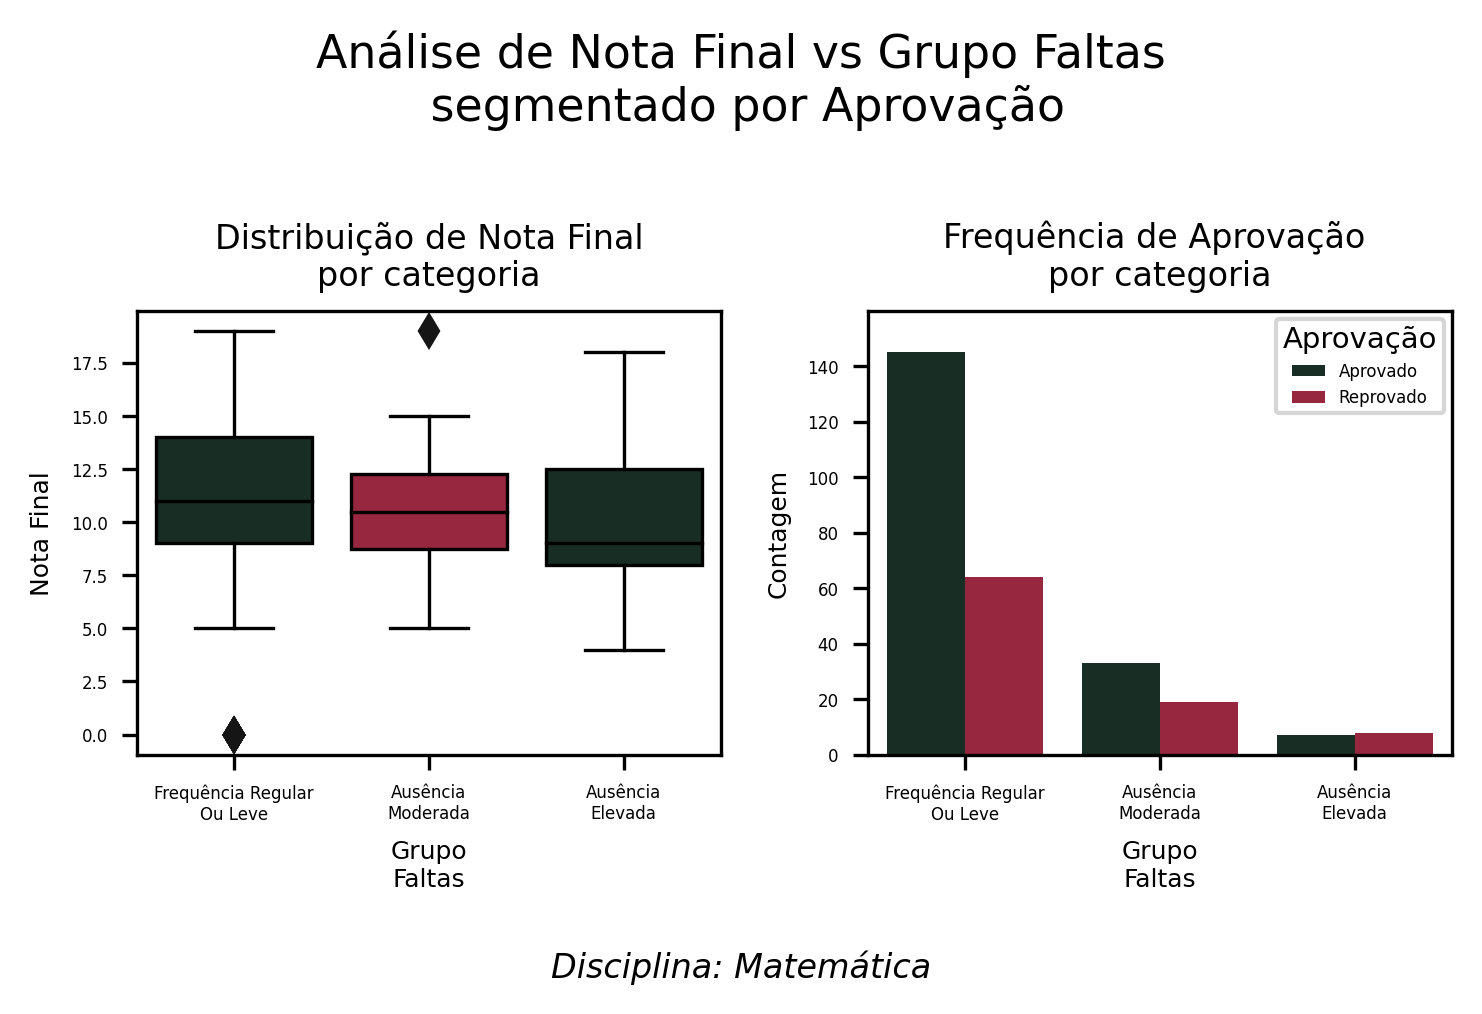

(<Figure size 1512x1008 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Distribuição de Nota Final\npor categoria'}, xlabel='Grupo\nFaltas', ylabel='Nota Final'>,
        <AxesSubplot:title={'center':'Frequência de Aprovação \npor categoria'}, xlabel='Grupo\nFaltas', ylabel='Contagem'>],
       dtype=object))

In [52]:
    
plot_boxplot_countplot(df,
                        x = 'grupo_faltas',
                        y = 'nota_final',
                        hue = 'aprovacao',
                        paleta=paleta_aprovacao_reprovacao,
                        materia= materia,
                        nome_arquivo='boxplot_faltas_aprovacao'
                       )

In [53]:
# Gerar a tabela com MultiIndex nas colunas
resumo_faltas = df[['grupo_faltas'] +notas+['idade']].groupby('grupo_faltas').agg(['mean', 'std', 'count']).round(2).reset_index()

# Renomear apenas o nível de métricas
resumo_faltas.columns = pd.MultiIndex.from_tuples([
    (col[0], 
     col[1].replace('mean', 'Média')
           .replace('std', 'Desvio Padrão')
           .replace('count', 'N')) if col[1] else col
    for col in resumo_faltas.columns
])
resumo_faltas


grupo_faltas  nota1                     nota2                \
                               Média Desvio Padrão    N  Média Desvio Padrão   
0  Frequência regular ou leve  10.94          3.40  209  10.91          3.89   
1           Ausência moderada  10.63          2.86   52  10.23          2.89   
2            Ausência elevada  10.87          3.76   15  10.53          3.80   

       nota_final                     idade                     
     N      Média Desvio Padrão    N  Média Desvio Padrão    N  
0  209      10.42          4.95  209  16.52          1.23  209  
1   52      10.44          2.97   52  17.08          1.15   52  
2   15      10.47          3.93   15  17.33          1.18   15

#### **Comparativo por grupo de faltas e status de aprovação**

In [54]:
# Função personalizada para retornar a primeira moda (se houver mais de uma)
def moda_unica(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

# Aplicar com a função no groupby
resumo = df[['grupo_faltas', 'aprovacao'] + notas].groupby(['grupo_faltas', 'aprovacao']).agg(
    ['mean', 'std', 'median', moda_unica]
).round(2).reset_index()


In [55]:
resumo

grupo_faltas  aprovacao  nota1                          \
                                           mean   std median moda_unica   
0  Frequência regular ou leve   Aprovado  12.43  2.84   12.0         11   
1  Frequência regular ou leve  Reprovado   7.56  1.76    7.0          7   
2           Ausência moderada   Aprovado  12.09  2.31   12.0         12   
3           Ausência moderada  Reprovado   8.11  1.73    8.0          6   
4            Ausência elevada   Aprovado  13.71  3.59   13.0         13   
5            Ausência elevada  Reprovado   8.38  1.41    8.5          8   

   nota2                         nota_final                          
    mean   std median moda_unica       mean   std median moda_unica  
0  12.77  2.58   13.0         13      13.01  2.57   12.0         10  
1   6.70  2.94    7.0          9       4.55  3.91    6.0          0  
2  11.85  2.14   12.0         12      12.18  2.02   12.0         11  
3   7.42  1.54    8.0          8       7.42  1.57    8.0          8  
4  13.57  3.36   13.0         10      13.71  3.04   13.0         11  
5   7.88  1.36    8.5          9       7.62  1.77    8.0          8


### 2.2.4 Notas e Faltas por Faixas Etárias

**Criação de grupos semânticos baseados em faixas etárias**

| Faixa Etária     | Critério                     | Interpretação                             |
|------------------|------------------------------|-------------------------------------------|
| **≤16 anos**     | Menores ou igual a Q1        | Estudantes jovens / dentro da média esperada |
| **17–18 anos**   | Entre Q1 e Q3 (mediana comum) | Faixa modal / esperada no Ensino Médio    |
| **≥19 anos**     | Acima de Q3                  | Estudantes mais velhos / possíveis repetições ou trajetória atípica |

###### *As faixas foram definidas com base nos quartis empíricos da distribuição da variável `idade`, refletindo perfis educacionais diferenciados.*


In [56]:
# Limites das faixas de idade e seus rótulos
bins_idade = [0, 16, 18, float('inf')]  # ≤16, 17–18, ≥19
labels_idade = ['≤16 anos', '17–18 anos', '≥19 anos']

# Criar nova coluna com a faixa etária
df['grupo_etario'] = pd.cut(df['idade'], bins=bins_idade, labels=labels_idade, right=True, include_lowest=True)


In [57]:
# Função personalizada para retornar a primeira moda (se houver mais de uma)
def moda_unica(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

# Gerar a tabela com MultiIndex nas colunas
resumo_idade = df[['grupo_etario'] +notas+['faltas']].groupby('grupo_etario').agg(['mean','median', 'std', 'count',moda_unica]).round(2).reset_index()

# Renomear apenas o nível de métricas
resumo_idade.columns = pd.MultiIndex.from_tuples([
    (col[0], 
     col[1].replace('mean', 'Média')
           .replace('std', 'Desvio Padrão')
           .replace('count', 'N')) if col[1] else col
    for col in resumo_idade.columns
])
resumo_idade.T

0           1         2
grupo_etario                ≤16 anos  17–18 anos  ≥19 anos
nota1        Média             11.17       10.66      10.4
             median             11.0        11.0      10.0
             Desvio Padrão      3.31        3.37      3.02
             N                   131         125        20
             moda_unica           10          10         8
nota2        Média              11.5       10.23       9.3
             median             12.0        10.0       9.0
             Desvio Padrão      3.72        3.65      3.16
             N                   131         125        20
             moda_unica           13           9         9
nota_final   Média             11.31        9.87      8.15
             median             11.0        10.0       9.0
             Desvio Padrão      4.37        4.61      4.53
             N                   131         125        20
             moda_unica           11          10         0
faltas       Média              4.43        6.72       9.2
             median              2.0         4.0       6.5
             Desvio Padrão      5.43        9.25      9.74
             N                   131         125        20
             moda_unica            0           0         0

In [58]:

# Gerar a tabela com MultiIndex nas colunas
resumo_idade = df[['grupo_etario'] +notas+['faltas']+['aprovacao']].groupby(['grupo_etario','aprovacao']).agg(['mean','median', 'std', 'count',moda_unica]).round(2).reset_index()

# Renomear apenas o nível de métricas
resumo_idade.columns = pd.MultiIndex.from_tuples([
    (col[0], 
     col[1].replace('mean', 'Média')
           .replace('std', 'Desvio Padrão')
           .replace('count', 'N')) if col[1] else col
    for col in resumo_idade.columns
])
resumo_idade.T

0          1           2           3  \
grupo_etario                ≤16 anos   ≤16 anos  17–18 anos  17–18 anos   
aprovacao                   Aprovado  Reprovado    Aprovado   Reprovado   
nota1        Média             12.35       7.91       12.41        7.53   
             median             12.0        8.0        12.0         7.0   
             Desvio Padrão      2.95        1.7        2.69        1.83   
             N                    96         35          80          45   
             moda_unica           12          7          12           6   
nota2        Média             13.09       7.11       12.19        6.76   
             median             13.0        7.0        12.0         8.0   
             Desvio Padrão      2.64       2.55        2.48        2.67   
             N                    96         35          80          45   
             moda_unica           13          7          11           9   
nota_final   Média             13.32       5.77       12.51        5.18   
             median             13.0        7.0        12.0         6.0   
             Desvio Padrão      2.59       3.39        2.44        3.75   
             N                    96         35          80          45   
             moda_unica           11          8          10           0   
faltas       Média              4.21       5.03        5.59        8.73   
             median              2.0        2.0         4.0         4.0   
             Desvio Padrão      5.03       6.44        5.86       13.16   
             N                    96         35          80          45   
             moda_unica            0          0           0           0   

                                   4          5  
grupo_etario                ≥19 anos   ≥19 anos  
aprovacao                   Aprovado  Reprovado  
nota1        Média             13.22       8.09  
             median             13.0        8.0  
             Desvio Padrão      1.64       1.45  
             N                     9         11  
             moda_unica           15          8  
nota2        Média             11.78       7.27  
             median             12.0        8.0  
             Desvio Padrão      1.39       2.72  
             N                     9         11  
             moda_unica           10          9  
nota_final   Média             11.67       5.27  
             median             11.0        8.0  
             Desvio Padrão      1.12       4.22  
             N                     9         11  
             moda_unica           11          0  
faltas       Média             11.67       7.18  
             median             12.0        4.0  
             Desvio Padrão      7.84      11.01  
             N                     9         11  
             moda_unica           12          0

### 2.2.5 Síntese Analítica dos Destaques

#### 1. Notas por Grupo de Aprovação

- **Distribuição dos grupos**:
  - Aprovados representam 67,03% da amostra (n = 185);
  - Reprovados correspondem a 32,97% (n = 91).

- **Notas por grupo**:
  - A média de `nota_final` entre os aprovados foi 12,89, contra apenas 5,42 entre os reprovados — uma diferença significativa de mais de 7 pontos;
  - O coeficiente de variação em `nota_final` foi bem mais alto entre os reprovados (CV = 0,72), evidenciando maior instabilidade no desempenho.

- **Comportamento dos outliers**:
  - Entre os reprovados, os outliers de `nota2` e `nota_final` estão concentrados em valores extremamente baixos (inclusive zero);
  - Entre os aprovados, outliers em `faltas` não comprometeram o desempenho, mesmo com alunos registrando mais de 20 faltas e mantendo notas finais acima de 13.

---

#### 2. Correlações Entre Variáveis Quantitativas

- **Correlação entre notas**:
  - `nota2` e `nota_final`: ρ = 0.95;
  - `nota1` e `nota_final`: ρ = 0.88;
  - `nota1` e `nota2`: ρ = 0.90;
  - Os altos coeficientes reforçam a estabilidade no desempenho ao longo das avaliações.

- **Faltas e desempenho**:
  - A correlação entre `faltas` e `nota_final` foi muito fraca (ρ = 0.01), indicando que a ausência isoladamente não explica variações no rendimento.

- **Idade e desempenho**:
  - Correlações fracas e negativas entre idade e notas (ρ até –0.21), sem efeito isolado relevante.

---

#### 3. Faltas e Desempenho Acadêmico

- Os **alunos aprovados** apresentaram maior variabilidade nas faltas (CV = 1,11), com **casos extremos** (até 25 faltas) mantendo médias elevadas em `nota_final` (≈13,71);
- Os **alunos reprovados**, mesmo com mediana de 4 faltas, tiveram `nota_final` média muito inferior;
- Esses resultados sugerem que **faltas elevadas não são determinantes para reprovação**, desde que acompanhadas de desempenho satisfatório nas avaliações.

---

#### 4. Desempenho por Grupo de Faltas

| Faixa de Faltas        | Critério                           | Interpretação                            |
|------------------------|------------------------------------|-------------------------------------------|
| **0–8**                | Até o 3º quartil (Q3 = 8)          | Frequência regular ou ausência leve       |
| **9–19**               | Entre Q3 e limite de outliers (20) | Ausência moderada                         |
| **≥20**                | Acima do limite de outliers        | Ausência elevada / comportamento extremo  |

- A média de `nota_final` foi relativamente estável entre os grupos (≈10,42 a 10,47), mas:
  - **Aprovados** com ausência elevada tiveram `nota_final` média de 13,71;
  - **Reprovados** com a mesma ausência ficaram com média de apenas 7,62;
- Isso reforça que **a ausência por si só não explica o fracasso escolar**, mas pode agravar o desempenho quando associada a outros fatores.

---

#### 5. Faixas de Faltas × Aprovação

- Diferenças marcantes entre aprovados e reprovados foram observadas em todos os níveis de ausência;
- Na ausência leve, os aprovados obtiveram média de `nota_final` = 13,01 contra apenas 4,55 dos reprovados — um **gap de quase 9 pontos**;
- Na ausência moderada, a diferença também foi expressiva (12,18 vs. 7,42);
- Alunos com ausência elevada mantiveram média alta se aprovados (13,71), indicando **resiliência acadêmica**.

---

#### 6. Desempenho por Faixa Etária

| Faixa Etária     | Critério          | Interpretação                               |
|------------------|-------------------|---------------------------------------------|
| **≤16 anos**     | Até 16 anos       | Estudantes mais jovens                      |
| **17–18 anos**   | 17 a 18 anos      | Faixa modal do ensino médio                 |
| **≥19 anos**     | 19 anos ou mais   | Perfil de repetência / trajetória atípica   |

- A média de `nota_final` decresceu com o aumento da idade: **11,31 → 9,87 → 8,15**;
- Faltas também aumentaram com a idade (4,43 → 6,72 → 9,2);
- O grupo de alunos ≥19 anos (n = 20) obteve as piores médias em todos os indicadores.

---

#### 7. Faixa Etária × Aprovação

- Aprovados apresentaram desempenho claramente superior em todas as faixas etárias;
- Reprovados ≤16 anos ainda tiveram `nota_final` média de 5,77 — muito abaixo do corte;
- A diferença de desempenho se manteve alta, com **gap de até 7,5 pontos entre aprovados e reprovados** em cada faixa etária;
- Mesmo os aprovados ≥19 anos mostraram desempenho inferior aos colegas mais jovens, indicando possível fragilidade acadêmica persistente.

Esses achados destacam o papel multifatorial do desempenho escolar, evidenciando que **faltas e idade influenciam o rendimento, mas não o determinam isoladamente**. O histórico de notas e a evolução ao longo do ano são os principais indicadores de aprovação.



## 2.3 Conclusão da Análise Quantitativa

A análise dos atributos quantitativos revelou padrões consistentes entre desempenho, frequência e faixa etária. Notas parciais mostraram-se altamente correlacionadas com a nota final, enquanto variáveis como `faltas` e `idade` demonstraram relações mais sutis, porém relevantes quando cruzadas com o status de aprovação.

A segmentação por faixas de ausência e idade permitiu identificar perfis de risco e possíveis trajetórias atípicas. Alunos com elevado número de faltas ou com idade mais avançada mantiveram desempenho inferior em média, mas não necessariamente foram reprovados — o que reforça a importância de considerar essas variáveis de forma interativa.

Esses achados sustentam hipóteses importantes para a próxima etapa do projeto: a seleção de atributos e construção de modelos preditivos. A análise bivariada serviu como base sólida para priorizar variáveis explicativas e entender nuances relevantes no perfil dos estudantes.


# 3. Análise de Atributos Categóricos, Perfis Estudantis e Segmentação de Desempenho

## 3.1 Visão Geral das Variáveis Categóricas Nominais e Ordinais


#### **Medidas Descritivas de Frequência**

In [59]:
add_features_describe_pd(df,colunas=variaveis_categoricas,estudo_frequencia=True )

Tamanho da amostra (categórico): 276


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,245,88.768116,0.724638
genero,2,Mulher,148,53.623188,0.724638
endereco,2,Urbano,218,78.985507,0.724638
status_parental,2,Juntos,246,89.130435,0.724638
profissao_mae,5,Outra profissão,101,36.594203,1.811594
profissao_pai,5,Outra profissão,149,53.985507,1.811594
motivo_escolha_escola,4,Curso específico,96,34.782609,1.449275
responsavel_legal,3,Mãe,195,70.652174,1.086957
apoio_escolar,2,Não,240,86.956522,0.724638


#### **Medidas Descritivas das Variáveis Ordinais**

In [60]:
add_features_describe_pd(df,colunas=variaveis_categoricas_ordinais)

Tamanho da amostra (numérico): 276.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
escolaridade_mae,2.742754,1.086672,0.0,2.0,3.0,4.00,4.0,4,2.89e-15,0.396
escolaridade_pai,2.543478,1.076152,0.0,2.0,2.0,3.25,4.0,2,2.50e-14,0.423
relacao_familiar,3.974638,0.879716,1.0,4.0,4.0,5.00,5.0,4,4.89e-17,0.221
tempo_livre,3.278986,1.036635,1.0,3.0,3.0,4.00,5.0,3,7.41e-12,0.316
frequencia_saidas,3.090580,1.135758,1.0,2.0,3.0,4.00,5.0,3,6.31e-12,0.367
saude,3.503623,1.407766,1.0,3.0,4.0,5.00,5.0,5,1.38e-15,0.402
tempo_estudo,2.000000,0.800000,1.0,1.0,2.0,2.00,4.0,2,3.33e-17,0.400
tempo_transporte,1.391304,0.620085,1.0,1.0,1.0,2.00,4.0,1,9.93e-24,0.446
alcool_dias_uteis,1.449275,0.849149,1.0,1.0,1.0,2.00,5.0,1,4.49e-25,0.586


### 3.1.1 Comentários Iniciais

Nesta seção, são apresentados os principais achados obtidos a partir da análise das variáveis categóricas (nominais e ordinais) relacionadas ao perfil sociodemográfico, familiar e escolar dos estudantes da disciplina de Matemática.

A base conta com **276 observações**, abrangendo 26 variáveis categóricas, das quais 11 são ordinais (com interpretação crescente de intensidade ou nível) e 15 são nominais. A maioria das variáveis possui **baixa diversidade de categorias efetivamente utilizadas**, com **predomínio acentuado de algumas modalidades específicas**.

**Principais destaques:**

- Variáveis como `escola`, `status_parental`, `apoio_escolar`, `frequentou_creche`, `interesse_ensino_superior` e `reprovacoes` apresentam **distribuição extremamente concentrada** em uma única categoria, com **mais de 85% dos estudantes** agrupados em uma única resposta. Esse padrão reduz a variabilidade informacional e sugere que essas variáveis devem ser tratadas com cautela em modelagens preditivas.

- Em `escola`, por exemplo, **88,8% dos alunos pertencem à instituição "Gabriel Pereira"**, o que evidencia **baixo poder discriminativo** da variável. O mesmo ocorre com `status_parental` (89,1% "juntos") e `apoio_escolar` (87% "não").

- Variáveis com distribuição mais equilibrada incluem `responsavel_legal`, `profissao_mae`, `motivo_escolha_escola` e `atividades_extracurriculares`, que apresentam diversidade mais alta de categorias e maior potencial explicativo.

- No conjunto de variáveis ordinais, destacam-se:
  - `reprovacoes`, com distribuição altamente assimétrica (78,9% com zero reprovações e CV > 2), indicando um padrão extremo e concentração no desempenho regular;
  - `tempo_transporte`, `tempo_estudo`, `alcool_dias_uteis` e `alcool_fim_semana` com distribuição fortemente enviesada para as menores categorias, refletindo baixos níveis de tempo de deslocamento, dedicação ao estudo e consumo de álcool nos dias úteis;
  - `relacao_familiar` e `tempo_livre` apresentam distribuição mais equilibrada, com CVs abaixo de 0,40 e boa representação nas categorias centrais (nível 3 ou 4).

- O **teste de normalidade de Shapiro-Wilk rejeitou a hipótese de normalidade para todas as variáveis ordinais** (p < 0,001), reforçando o caráter assimétrico e categórico desses dados.

De forma geral, a análise sugere que há um número considerável de variáveis com **baixa variabilidade entre os estudantes**, o que poderá influenciar negativamente sua capacidade preditiva em modelos supervisionados. As variáveis com maior dispersão e distribuição equilibrada devem ser priorizadas nas etapas seguintes de seleção de atributos.



## 3.2 Distribuição dos Atributos Categóricos e Suas Relações com a Aprovação



In [61]:
registros = []
df_temp = df.copy()
df_temp['aprov_bin'] = df_temp['aprovacao'].map({'Aprovado': 1, 'Reprovado': 0})


n_total = len(df)

for var in variaveis_categoricas:
    dist = df[var].value_counts(dropna=False)
    taxa_aprov = df_temp.groupby(var)['aprov_bin'].mean()

    for cat, count in dist.items():
        registros.append({
            'Variável': var,
            'Categoria': cat,
            'Frequência Absoluta': count,
            'Frequência Relativa (%)': round(100 * count / n_total, 2),
            'Taxa de Aprovação (%)': round(100 * taxa_aprov.get(cat, 0), 2)
        })

resultado = pd.DataFrame(registros)
resultado = resultado.sort_values(by=['Variável', 'Frequência Absoluta'], ascending=[True, False]).reset_index(drop=True)
resultado

,Variável,Categoria,Frequência Absoluta,Frequência Relativa (%),Taxa de Aprovação (%)
0,acesso_internet,Sim,232,84.06,67.67
1,acesso_internet,Não,44,15.94,63.64
2,alcool_dias_uteis,1,197,71.38,70.56
3,alcool_dias_uteis,2,50,18.12,60.00
4,alcool_dias_uteis,3,17,6.16,58.82
5,alcool_dias_uteis,4,8,2.90,37.50
6,alcool_dias_uteis,5,4,1.45,75.00
7,alcool_fim_semana,1,107,38.77,68.22
8,alcool_fim_semana,2,59,21.38,71.19
9,alcool_fim_semana,3,55,19.93,72.73


> ### 3.2.1 Perfil Demográfico e Estrutural
>
> - **Gênero**: A distribuição por gênero é relativamente equilibrada, com leve maioria feminina (53,6%). A taxa de aprovação entre os homens (68,75%) foi levemente superior à das mulheres (65,54%), mas sem disparidades expressivas.
>
> - **Endereço**: A maioria reside em áreas urbanas (79%), com taxa de aprovação de 69,27%, enquanto estudantes da zona rural apresentaram taxa inferior (58,62%), sugerindo possível desigualdade no acesso a recursos educacionais.
>
> - **Estado civil dos pais**: Alunos com pais juntos (89,1% da amostra) tiveram 65,85% de aprovação. Curiosamente, filhos de pais separados apresentaram desempenho superior (76,67%), possivelmente associado a outros fatores compensatórios.
>
> - **Tamanho da família**: Estudantes de famílias com até 3 membros apresentaram aprovação de 71,08%, acima dos 65,28% entre alunos de famílias maiores — o que pode indicar maior suporte individualizado no contexto familiar.

---

> ### 3.2.2 Condições Socioeconômicas e Educacionais
>
> - **Escolaridade dos pais**:
>   - Mães com escolaridade nível 4 apresentaram maior taxa de aprovação (74,73%);
>   - Pais com escolaridade 4 também se destacaram (76,81%);
>   - Níveis mais baixos (0 ou 1) associaram-se a menores taxas de aprovação (<60%), sugerindo que o capital educacional dos pais influencia positivamente o desempenho dos filhos.
>
> - **Profissão dos pais**:
>   - Pais e mães professores aparecem entre os grupos com maior aprovação (pai: 78,95%; mãe: 66,67%);
>   - Profissões generalistas ou da área de serviços tiveram desempenho inferior — por exemplo, pais em "serviços" com 58,23%.
>
> - **Motivo da escolha da escola**:
>   - Motivos pessoais ("outro motivo") resultaram na maior taxa de aprovação (76,92%);
>   - Já os motivos tradicionais como "curso específico" e "proximidade" resultaram em taxas mais baixas (~61–68%), indicando que decisões mais estratégicas podem refletir maior engajamento acadêmico.
>
> - **Responsável legal**:
>   - Quando a mãe é a responsável legal (71% dos casos), a taxa de aprovação foi 68,21%;
>   - Quando o pai é o responsável, o desempenho é semelhante (69,49%);
>   - Alunos sob responsabilidade de "outros" obtiveram a menor taxa (50%).

---

> ### 3.2.3 Acompanhamento e Apoio Familiar e Escolar
>
> - **Apoio escolar**:
>   - A grande maioria dos alunos não recebeu apoio escolar (87%), mas esse grupo teve aprovação superior (69,17%) àqueles que receberam (52,78%), sugerindo que o apoio foi acionado após dificuldades já instaladas.
>
> - **Apoio familiar**:
>   - Alunos sem apoio declarado surpreenderam com maior taxa de aprovação (71,29%) em comparação com os que relataram apoio (64,57%), o que pode estar relacionado a autonomia e autogerenciamento.
>
> - **Relacionamento familiar**:
>   - Estudantes que classificaram sua relação familiar como ótima (nível 5) tiveram aprovação de 72,37%;
>   - Já os que atribuíram níveis intermediários ou baixos (nível 3 ou menos) apresentaram taxas inferiores (<60%).

---

> ### 3.2.4 Hábitos e Estilo de Vida
>
> - **Consumo de álcool – dias úteis**:
>   - Alunos que não consomem álcool durante a semana (nível 1) tiveram a melhor taxa de aprovação (70,56%);
>   - O desempenho cai conforme o consumo aumenta, chegando a apenas 37,5% no nível 4.
>
> - **Consumo de álcool – fins de semana**:
>   - Níveis moderados (nível 2 ou 3) apresentam melhores taxas (71–73%);
>   - Níveis elevados (4 ou 5) reduzem a taxa para até 50%, indicando padrão de risco.
>
> - **Relacionamento amoroso**:
>   - Estudantes sem relacionamento têm taxa de aprovação de 70,65%, superior aos que possuem vínculo romântico (59,78%), possivelmente devido a menor sobrecarga emocional.
>
> - **Atividades extracurriculares e aulas particulares**:
>   - Participar de atividades extracurriculares não gerou diferença expressiva;
>   - Aulas particulares, por outro lado, mostraram efeito positivo: 70,80% de aprovação entre os que receberam.

---

> ### 3.2.5 Condições Acadêmicas e Comportamento Estudantil
>
> - **Reprovações anteriores**:
>   - Alunos sem reprovações tiveram 74,77% de aprovação;
>   - Já estudantes com 1 reprovação caem para 51,35%;
>   - Com duas ou mais reprovações, a taxa é crítica: 9,09% (2 reprovações) e 20% (3 reprovações).
>
> - **Tempo de estudo diário**:
>   - Melhor desempenho entre os que estudam 3 horas por dia (72,5%);
>   - Alunos que estudam apenas 1 hora tiveram menor aprovação (63,89%);
>   - Aqueles que estudam 4 horas não se destacaram (62,5%), indicando que apenas tempo não garante desempenho.
>
> - **Tempo livre diário**:
>   - Melhor taxa de aprovação está entre 2 e 4 horas livres (≈67–69%);
>   - Tempo livre muito curto (1h) se associou a menor desempenho (53,85%).
>
> - **Tempo de transporte**:
>   - Alunos que gastam 1 hora para chegar à escola apresentaram 69,73% de aprovação;
>   - O desempenho cai à medida que o deslocamento aumenta: 63,64% (2h) → 54,55% (3h) → 33,33% (4h).


## 3.3 Análise Bivariada entre Atributos Categóricos, Ordinais e Métricas de Desempenho
Objetivo: 
- Investigar associações entre variáveis não diretamente relacionadas à aprovação e verificar correlações relevantes para seleção de atributos.


### 3.3.1 Correlação entre Variáveis Ordinais Descritivas

In [62]:
corr_ord = df[variaveis_categoricas_ordinais].corr(method= 'spearman')


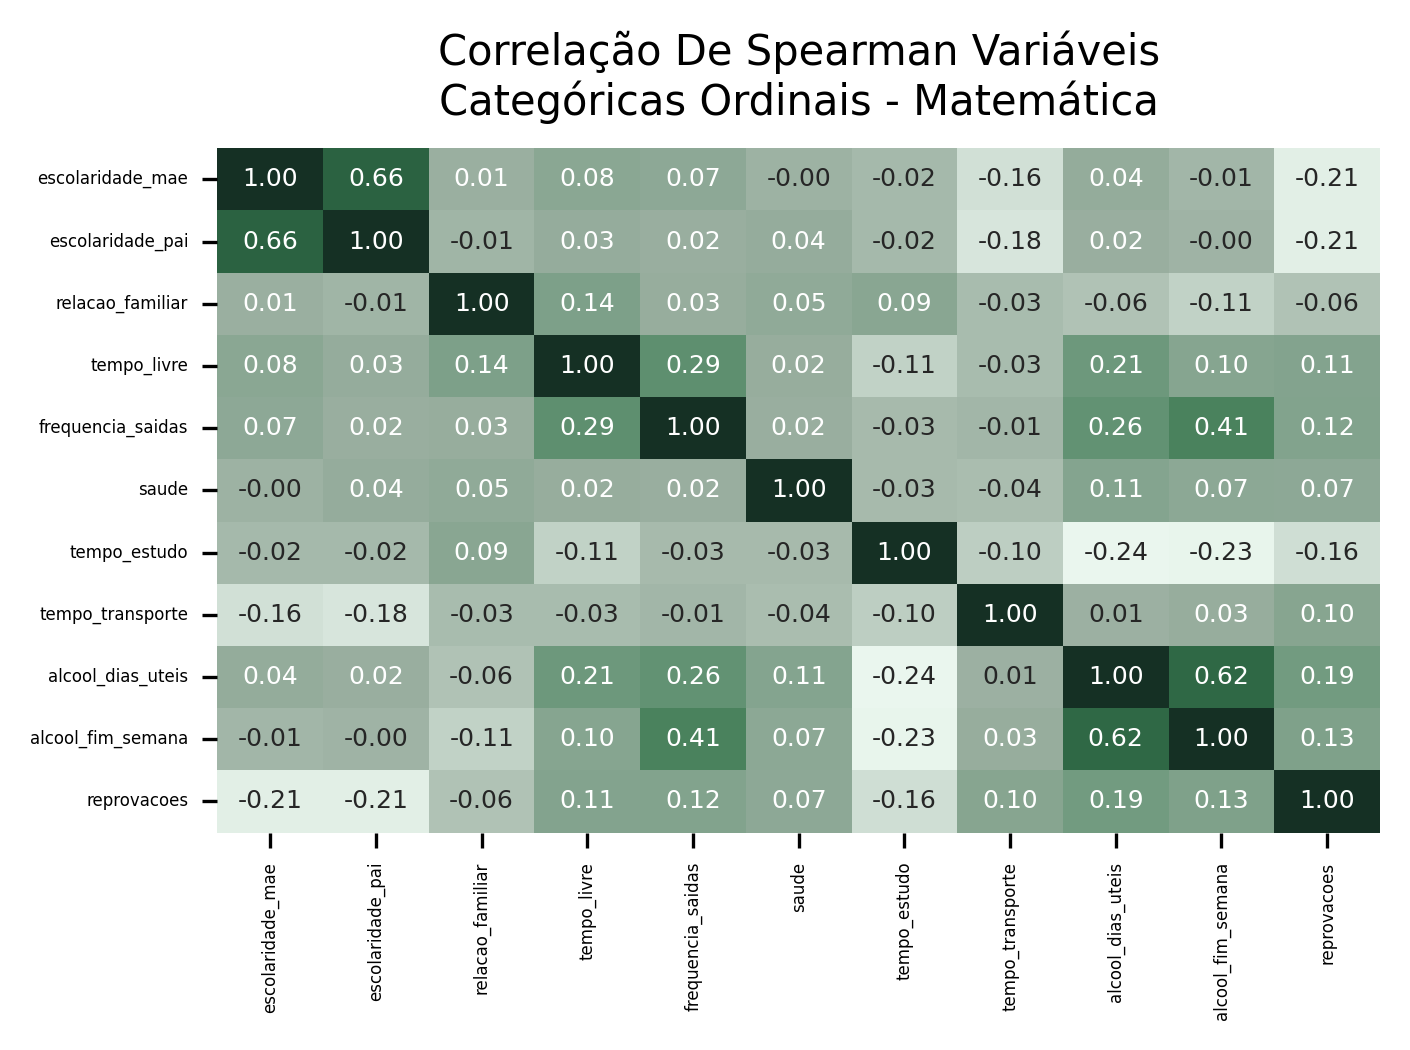

In [63]:
custom_heatmap(matriz_corr = corr_ord,
               cores = cores,
               n_arq ='heatmap_ordinais',
               titulo = 'Correlação de Spearman \n Variáveis Categóricas Ordinais' ,
               disciplina=materia)

### 3.3.2 Correlação entre Variáveis Ordinais e Métricas de Desempenho

In [64]:
corr_ord = df[variaveis_categoricas_ordinais+notas+['faltas']].corr(method= 'spearman')

In [65]:
corr_long = corr_ord.where(np.tril(np.ones(corr_ord.shape), k=-1).astype(bool)).stack().reset_index()
corr_long.columns = ['Notas e Faltas','Categoricas Ordinais', 'Correlação']

In [66]:
corr_ord_n = corr_long[corr_long['Notas e Faltas'].isin(['nota1', 'nota2', 'nota_final','faltas'])]

heatmap_df = corr_ord_n.pivot(index='Categoricas Ordinais', columns='Notas e Faltas', values='Correlação')
heatmap_df.dropna(inplace=True)

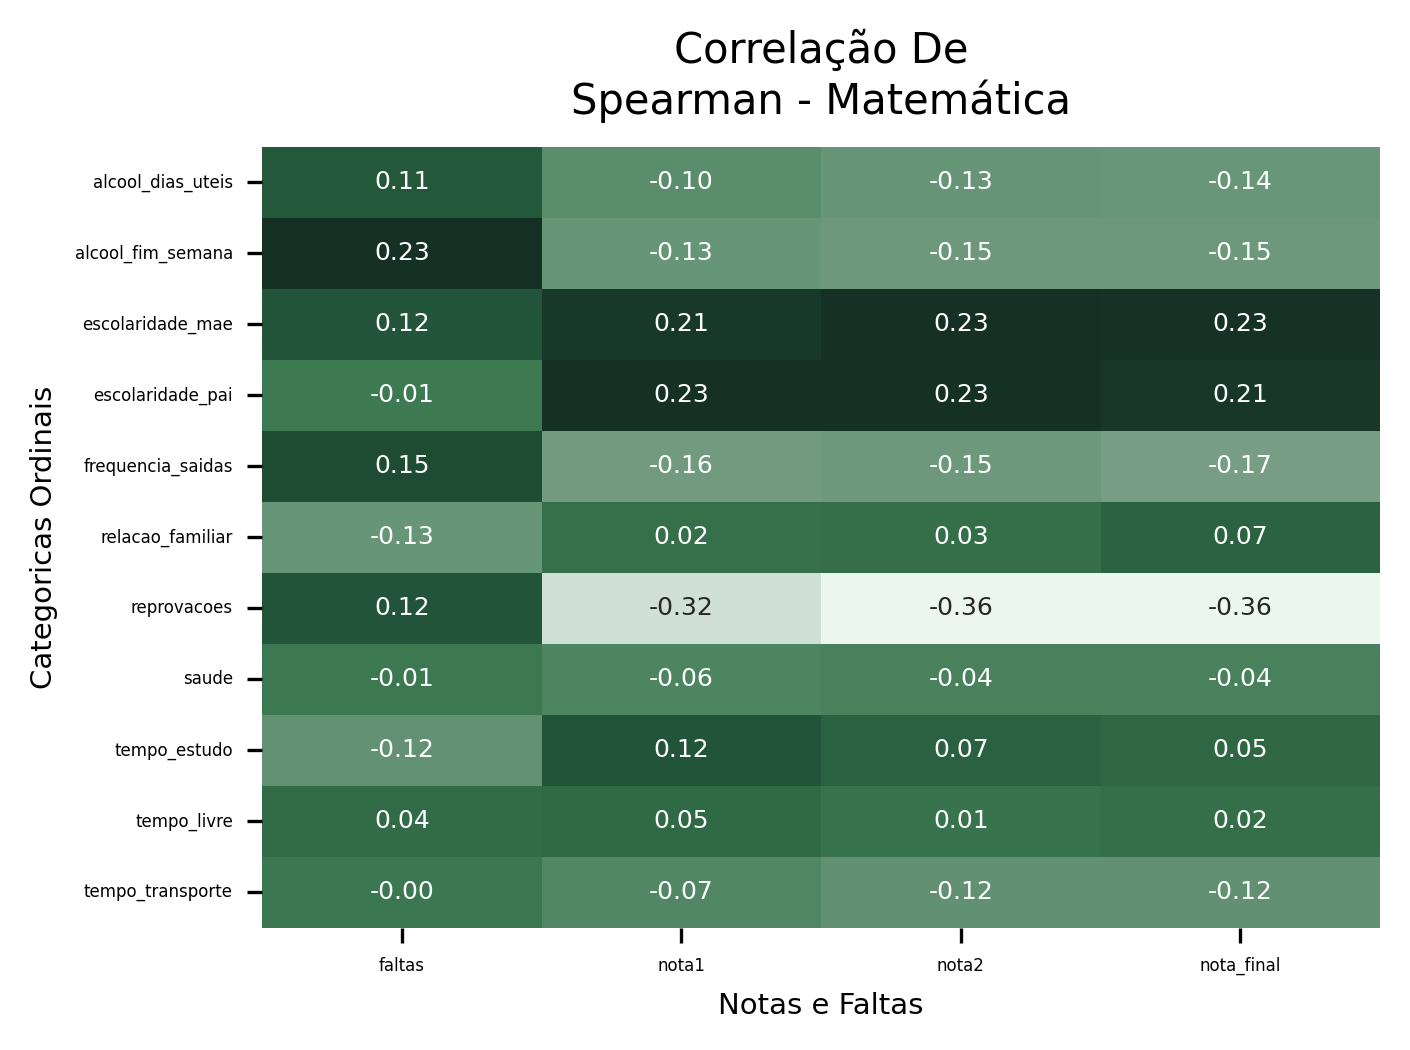

In [67]:
custom_heatmap(matriz_corr = heatmap_df,
               cores = cores,
               n_arq ='heatmap_ordinais',
              titulo = 'Correlação de Spearman' ,
               disciplina=materia)


### 3.3.2 Relações Familiares e Educacionais

##### **status_parental x responsavel legal**

In [68]:
pd.crosstab(df['status_parental'], df['responsavel_legal'], normalize='index') * 100

responsavel_legal,Mãe,Outro responsável,Pai
status_parental,,,
Juntos,69.918699,7.317073,22.764228
Separados,76.666667,13.333333,10.000000


**escolaridade do responsável legal**

In [69]:
pd.crosstab(df['responsavel_legal'], df['escolaridade_mae'], normalize='index') * 100

escolaridade_mae,0,1,2,3,4
responsavel_legal,,,,,
Mãe,0.000000,13.846154,26.153846,23.076923,36.923077
Outro responsável,0.000000,31.818182,22.727273,31.818182,13.636364
Pai,1.694915,13.559322,32.203390,25.423729,27.118644


In [70]:
pd.crosstab(df['responsavel_legal'], df['escolaridade_pai'], normalize='index') * 100

escolaridade_pai,0,1,2,3,4
responsavel_legal,,,,,
Mãe,0.512821,22.051282,31.282051,21.538462,24.615385
Outro responsável,0.000000,31.818182,31.818182,18.181818,18.181818
Pai,0.000000,5.084746,30.508475,35.593220,28.813559


##### **escolaridade e profissões dos pais**

In [71]:
pd.crosstab(df['escolaridade_mae'], df['escolaridade_pai'], normalize='index') * 100

escolaridade_pai,0,1,2,3,4
escolaridade_mae,,,,,
0,0.000000,0.000000,100.000000,0.000000,0.000000
1,2.380952,59.523810,33.333333,4.761905,0.000000
2,0.000000,25.333333,50.666667,16.000000,8.000000
3,0.000000,11.940299,31.343284,38.805970,17.910448
4,0.000000,1.098901,13.186813,29.670330,56.043956


In [72]:
pd.crosstab(df['profissao_mae'], df['profissao_pai'], normalize='index') * 100

profissao_pai,Dono de casa,Outra profissão,Professor(a),Serviços,Área da saúde
profissao_mae,,,,,
Dona de casa,8.823529,50.000000,0.000000,35.294118,5.882353
Outra profissão,0.990099,77.227723,2.970297,16.831683,1.980198
Professor(a),4.444444,31.111111,22.222222,33.333333,8.888889
Serviços,6.944444,37.500000,8.333333,41.666667,5.555556
Área da saúde,0.000000,54.166667,0.000000,20.833333,25.000000


In [73]:
pd.crosstab(df['escolaridade_mae'], df['profissao_mae'], normalize='index') * 100

profissao_mae,Dona de casa,Outra profissão,Professor(a),Serviços,Área da saúde
escolaridade_mae,,,,,
0,100.000000,0.000000,0.000000,0.000000,0.000000
1,38.095238,52.380952,0.000000,7.142857,2.380952
2,17.333333,49.333333,0.000000,30.666667,2.666667
3,5.970149,44.776119,2.985075,40.298507,5.970149
4,0.000000,13.186813,47.252747,20.879121,18.681319


In [74]:
pd.crosstab(df['escolaridade_pai'], df['profissao_pai'], normalize='index') * 100

profissao_pai,Dono de casa,Outra profissão,Professor(a),Serviços,Área da saúde
escolaridade_pai,,,,,
0,0.000000,100.000000,0.000000,0.000000,0.000000
1,5.660377,69.811321,1.886792,20.754717,1.886792
2,4.651163,59.302326,0.000000,32.558140,3.488372
3,2.985075,56.716418,1.492537,34.328358,4.477612
4,2.898551,31.884058,24.637681,24.637681,15.942029



### 3.3.3 Estilo de Vida e Organização do Tempo


In [75]:

# Tempo_livre × frequencia_saidas
pd.crosstab(df['tempo_livre'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
tempo_livre,,,,,
1,23.076923,38.461538,30.769231,0.000000,7.692308
2,8.695652,47.826087,23.913043,15.217391,4.347826
3,3.883495,27.184466,38.834951,19.417476,10.679612
4,3.797468,17.721519,29.113924,37.974684,11.392405
5,8.571429,25.714286,8.571429,17.142857,40.000000


In [76]:
# Tempo_livre × tempo_estudo
pd.crosstab(df['tempo_livre'], df['tempo_estudo'], normalize='index') * 100


tempo_estudo,1,2,3,4
tempo_livre,,,,
1,7.692308,69.230769,7.692308,15.384615
2,34.782609,45.652174,10.869565,8.695652
3,20.388350,54.368932,18.446602,6.796117
4,21.518987,59.493671,17.721519,1.265823
5,48.571429,42.857143,2.857143,5.714286


In [77]:
# Relacao_familiar × frequência de saídas
pd.crosstab(df['relacao_familiar'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
relacao_familiar,,,,,
1,20.000000,80.000000,0.000000,0.000000,0.000000
2,8.333333,16.666667,16.666667,16.666667,41.666667
3,6.818182,29.545455,31.818182,20.454545,11.363636
4,5.755396,28.057554,28.057554,25.899281,12.230216
5,5.263158,26.315789,34.210526,21.052632,13.157895


In [78]:
# Tempo_transporte × frequencia_saidas
pd.crosstab(df['tempo_transporte'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
tempo_transporte,,,,,
1,5.405405,28.648649,29.729730,22.702703,13.513514
2,7.792208,28.571429,25.974026,24.675325,12.987013
3,9.090909,9.090909,54.545455,18.181818,9.090909
4,0.000000,66.666667,0.000000,0.000000,33.333333


In [79]:
# tempo_transporte × tempo_estudo
pd.crosstab(df['tempo_transporte'], df['tempo_estudo'], normalize='index') * 100


tempo_estudo,1,2,3,4
tempo_transporte,,,,
1,23.783784,54.054054,15.675676,6.486486
2,28.571429,53.246753,12.987013,5.194805
3,54.545455,45.454545,0.000000,0.000000
4,0.000000,66.666667,33.333333,0.000000


In [80]:
# Alcool_dias_uteis × frequencia_saidas
pd.crosstab(df['alcool_dias_uteis'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
alcool_dias_uteis,,,,,
1,8.121827,31.979695,30.964467,18.781726,10.152284
2,2.000000,22.000000,26.000000,34.000000,16.000000
3,0.000000,11.764706,35.294118,29.411765,23.529412
4,0.000000,12.500000,12.500000,50.000000,25.000000
5,0.000000,25.000000,0.000000,0.000000,75.000000


In [81]:
# Alcool_fim_semana × frequencia_saidas
pd.crosstab(df['alcool_fim_semana'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
alcool_fim_semana,,,,,
1,12.149533,39.252336,23.364486,19.626168,5.607477
2,5.084746,33.898305,42.372881,11.864407,6.779661
3,0.000000,18.181818,43.636364,25.454545,12.727273
4,2.702703,10.810811,13.513514,45.945946,27.027027
5,0.000000,11.111111,11.111111,22.222222,55.555556


In [82]:
# Alcool_dias_uteis × genero
pd.crosstab(df['alcool_dias_uteis'], df['genero'], normalize='index') * 100


genero,Homem,Mulher
alcool_dias_uteis,,
1,37.563452,62.436548
2,58.000000,42.000000
3,82.352941,17.647059
4,87.500000,12.500000
5,100.000000,0.000000


In [83]:
# Alcool_fim_semana × idade
pd.crosstab(df['alcool_fim_semana'], df['idade'], normalize='index') * 100


idade,15,16,17,18,19,20,21
alcool_fim_semana,,,,,,,
1,33.644860,27.102804,14.018692,19.626168,5.607477,0.000000,0.000000
2,11.864407,32.203390,25.423729,18.644068,11.864407,0.000000,0.000000
3,14.545455,14.545455,38.181818,21.818182,9.090909,0.000000,1.818182
4,16.216216,35.135135,35.135135,13.513514,0.000000,0.000000,0.000000
5,0.000000,27.777778,38.888889,27.777778,0.000000,5.555556,0.000000


In [84]:
# Alcool_dias_uteis × idade
pd.crosstab(df['alcool_dias_uteis'], df['idade'], normalize='index') * 100



idade,15,16,17,18,19,20,21
alcool_dias_uteis,,,,,,,
1,23.350254,28.934010,22.335025,18.781726,6.598985,0.0,0.000000
2,14.000000,24.000000,34.000000,22.000000,6.000000,0.0,0.000000
3,17.647059,11.764706,35.294118,17.647059,11.764706,0.0,5.882353
4,12.500000,12.500000,37.500000,25.000000,0.000000,12.5,0.000000
5,0.000000,50.000000,25.000000,25.000000,0.000000,0.0,0.000000


### 3.3.5 Síntese Analítica dos Destaques

A seção sintetiza os principais padrões identificados a partir das análises de associação entre variáveis categóricas, com destaque para a interdependência entre aspectos familiares, comportamentais e desempenho acadêmico na disciplina de Matemática.

---

#### **1. Relações Familiares e Educacionais**

- **Configuração familiar e responsável legal**:
  - Alunos com pais separados apresentam distribuição distinta quanto ao responsável legal: enquanto 70,4% dos estudantes com pais juntos têm a mãe como responsável, esse percentual sobe para 74,6% em famílias separadas, mas com aumento expressivo de “outros responsáveis” (15,3%);
  - A presença paterna como responsável diminui significativamente em contextos de separação (de 24,3% para 10,2%).

- **Escolaridade dos responsáveis**:
  - Mães tendem a apresentar maior escolaridade do que pais — com destaque para o nível 4 (29,2%);
  - Já pais concentram-se mais nos níveis 2 e 3, com distribuição mais homogênea;
  - “Outros responsáveis” tendem a níveis intermediários, com maior frequência nos níveis 1 e 3.

- **Associação entre escolaridade e profissão dos pais**:
  - Há forte relação entre escolaridade e ocupação: mães com nível 4 concentram-se em profissões de maior prestígio, como professoras (40%) ou área da saúde (20%);
  - Pais com nível 4 também se destacam nas categorias de professor (27%) e outra profissão qualificada (32%);
  - Por outro lado, mães com escolaridade 0 ou 1 concentram-se como donas de casa (>46%), enquanto pais com escolaridade 1 atuam majoritariamente em serviços (24,8%) ou ocupações indefinidas.

- **Correlação entre escolaridade dos pais**:
  - Correlação moderada positiva entre `escolaridade_mae` e `escolaridade_pai` (ρ = 0.66), sugerindo que casais tendem a ter níveis educacionais semelhantes.

---

#### **2. Estilo de Vida e Organização do Tempo**

- **Relação entre tempo livre e frequência de saídas**:
  - A frequência de saídas aumenta com o tempo livre: alunos com 5h de tempo livre têm 50% de probabilidade de sair 5 vezes/semana, enquanto os com 1h se concentram em até 2 saídas semanais;
  - Alunos com tempo livre intermediário (2–3h) apresentam maior equilíbrio.

- **Tempo livre e tempo de estudo**:
  - Tempo de estudo tende a decrescer entre alunos com 5h de tempo livre — 87,5% estudam no máximo 2h/dia;
  - Já alunos com 3h de tempo livre se distribuem de forma mais balanceada, com até 20% estudando 3h diárias.

- **Tempo de transporte e desempenho**:
  - Deslocamentos mais longos (>2h) associam-se a maior frequência de saídas (46% saem 5x/semana) e menor tempo de estudo — 61,5% estudam no máximo 2h por dia;
  - Indica possível prejuízo à rotina escolar e menor aproveitamento acadêmico.

- **Consumo de álcool e comportamento**:
  - Maior consumo de álcool (níveis 4 e 5) está diretamente relacionado a maior frequência de saídas (até 57% saem 5 vezes/semana);
  - Alunos que consomem álcool com maior frequência são, em sua maioria, homens (até 85% na categoria 5) e com idades entre 17 e 18 anos;
  - Correlação significativa entre `alcool_dias_uteis` e `frequencia_saidas` (ρ = 0.26), além de correlação entre os dois tipos de consumo alcoólico (ρ = 0.62).

- **Relações familiares e saídas**:
  - Estudantes com piores avaliações da relação familiar (nível 1 ou 2) tendem a perfis mais desorganizados, com alta ou muito baixa frequência de saídas;
  - Relações familiares estáveis (níveis 4 e 5) concentram-se em frequências moderadas de saídas (2 a 4 vezes/semana).

---

#### **3. Correlações com Desempenho Acadêmico**

- **Variáveis mais correlacionadas negativamente com notas**:
  - `reprovacoes` é a variável ordinal mais associada a baixo desempenho: ρ = –0.36 com `nota_final`, também com forte impacto sobre `nota1` e `nota2`;
  - `frequencia_saidas` e `alcool_fim_semana` têm correlação negativa moderada (ρ ≈ –0.15) com desempenho.

- **Variáveis com correlação positiva com notas**:
  - `escolaridade_mae` e `escolaridade_pai` apresentam correlações positivas com todas as notas (ρ ≈ 0.21–0.23);
  - `tempo_estudo` também tem correlação fraca positiva com `nota1` (ρ = 0.12), mas reduzida para `nota_final`.

- **Relações entre variáveis ordinais**:
  - Além do consumo de álcool, a `frequencia_saidas` correlaciona-se positivamente com `tempo_livre` (ρ = 0.29), reforçando o padrão de lazer mais intenso entre quem dispõe de mais tempo ocioso;
  - `tempo_estudo` e `tempo_transporte` apresentam correlação negativa entre si (ρ = –0.24), sugerindo que deslocamentos longos reduzem o tempo dedicado ao estudo.

---

Esses achados destacam a importância da integração entre fatores individuais, familiares e logísticos na construção do desempenho acadêmico, reforçando a complexidade das trajetórias escolares. Elementos como tempo de deslocamento, arranjos familiares e estilos de vida se revelam tão relevantes quanto variáveis acadêmicas tradicionais.



---

## 3.4 Avaliação de Atributos com Índice de Perfil Composto



### 3.4.1 Metodologia de Seleção

*Para criação das tabelas da seção calculo-se um índice composto de perfilamento, combinando critérios de distribuição, diversidade e impacto na variável de interesse (nota final ou faltas). Os critérios avaliados foram:*

1. Frequência mínima absoluta e relativa:
A variável deve apresentar frequência mínima por categoria, ajustada ao tamanho da amostra e ao número total de categorias. Isso evita categorias muito raras.

2. Entropia de Shannon (diversidade):
Mede o grau de equilíbrio entre as categorias. Quanto mais equilibradas, maior a entropia e, potencialmente, maior a capacidade da variável de discriminar padrões.

3. Gap de desempenho entre categorias:
Representa a diferença entre as médias da variável de interesse (ex.: nota final) entre as categorias da variável avaliada. Quanto maior essa diferença, maior a capacidade da variável em segmentar o desempenho.

5. Score de Perfil Composto:
Índice final é calculado como a média ponderada da entropia normalizada e do gap de desempenho, permitindo ordenar as variáveis mais informativas.

6. Alertas de dispersão:
Variáveis com alta dispersão (> 80%) e muitas categorias são sinalizadas, pois podem ser menos interpretáveis ou sofrer com sparsidade em modelos.

Este método permite filtrar automaticamente variáveis nominais relevantes para auxiliar na seleção de atributos qualitativos de interesse.

### 3.4.2 Aplicação do Índice de Perfil por Variável de Desempenho
A seguir, aplicamos o índice composto para diferentes variáveis de desempenho: as três notas individuais, a média das notas e a quantidade de faltas.


##### **Nota 1**

In [85]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas,coluna_avaliada='nota1')

Tamanho da amostra (categórico): 276


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_mae,5,0.851,6.095
escolaridade_pai,5,0.864,3.396
profissao_pai,5,0.734,2.887
profissao_mae,5,0.923,1.710
alcool_fim_semana,5,0.911,1.585
frequencia_saidas,5,0.929,1.433
saude,5,0.941,1.091
tempo_livre,5,0.889,1.290
tempo_estudo,4,0.815,1.550


##### **Nota 2**

In [86]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas,coluna_avaliada='nota2')

Tamanho da amostra (categórico): 276


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_pai,5,0.864,5.755
escolaridade_mae,5,0.851,5.643
frequencia_saidas,5,0.929,1.747
alcool_fim_semana,5,0.911,1.838
profissao_mae,5,0.923,1.766
saude,5,0.941,1.619
profissao_pai,5,0.734,2.075
tempo_estudo,4,0.815,1.033


##### **Nota Final**

In [87]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas)

Tamanho da amostra (categórico): 276


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_pai,5,0.864,7.113
escolaridade_mae,5,0.851,6.190
saude,5,0.941,2.220
frequencia_saidas,5,0.929,1.948
profissao_mae,5,0.923,1.757
alcool_fim_semana,5,0.911,1.592
motivo_escolha_escola,4,0.940,1.279
profissao_pai,5,0.734,2.689
relacionamento_romantico,2,0.918,1.212


##### **Média das 3 Notas** 

In [88]:
df_copy = df.copy()
df_copy['media_notas'] = (df_copy['nota1'] + df_copy['nota2'] + df_copy['nota_final'])/3

avaliacao_variacao_pontuacao_media_por_categoria(df_copy,variaveis_categoricas,coluna_avaliada='media_notas')

Tamanho da amostra (categórico): 276


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_mae,5,0.851,5.976
escolaridade_pai,5,0.864,5.421
profissao_mae,5,0.923,1.735
frequencia_saidas,5,0.929,1.685
alcool_fim_semana,5,0.911,1.671
saude,5,0.941,1.476
profissao_pai,5,0.734,2.542
tempo_estudo,4,0.815,1.171


**Faltas**

In [89]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas,coluna_avaliada='faltas')

Tamanho da amostra (categórico): 276


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
tempo_livre,5,0.889,7.516
escolaridade_mae,5,0.851,7.119
escolaridade_pai,5,0.864,4.360
alcool_fim_semana,5,0.911,3.988
motivo_escolha_escola,4,0.940,3.374
relacao_familiar,5,0.747,4.232
relacionamento_romantico,2,0.918,2.891
tempo_estudo,4,0.815,3.326
frequencia_saidas,5,0.929,2.432



### 3.4.3 Considerações para a Seleção de Atributos


In [90]:
for n in notas:

    print(f'Análise de Impacto - {n} :\n')
    print('---'*20)
    display(diagnostico_impacto_variaveis_categoricas(df,
                                          variaveis_categoricas=variaveis_categoricas,
                                          materia=materia,
                                          coluna_avaliada=n))

Análise de Impacto - nota1 :

------------------------------------------------------------
[MODERADO] escola → desequilíbrio: 0.89 | gap: 0.63
[FRACO] genero → desequilíbrio: 0.54 | gap: 0.53
[MODERADO] endereco → desequilíbrio: 0.79 | gap: 0.44
[MODERADO] status_parental → desequilíbrio: 0.89 | gap: 0.36
[MODERADO] profissao_mae → desequilíbrio: 0.37 | gap: 1.71
[MODERADO] profissao_pai → desequilíbrio: 0.54 | gap: 2.89
[FRACO] motivo_escolha_escola → desequilíbrio: 0.35 | gap: 0.90
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 0.80
[MODERADO] apoio_escolar → desequilíbrio: 0.87 | gap: 1.88
[FRACO] apoio_familiar → desequilíbrio: 0.63 | gap: 0.50
[FRACO] aulas_particulares → desequilíbrio: 0.50 | gap: 0.01
[FRACO] atividades_extracurriculares → desequilíbrio: 0.51 | gap: 0.42
[MODERADO] frequentou_creche → desequilíbrio: 0.80 | gap: 0.59
[MODERADO] interesse_ensino_superior → desequilíbrio: 0.95 | gap: 2.51
[MODERADO] acesso_internet → desequilíbrio: 0.84 | gap: 0.34
[FRAC

,variavel,tipo_analise,gap,desequilibrio,impacto
0,escolaridade_mae,analise_matematica,6.095238,0.329710,moderado
1,reprovacoes,analise_matematica,4.808257,0.789855,forte
2,escolaridade_pai,analise_matematica,3.396226,0.311594,moderado
3,tempo_transporte,analise_matematica,3.338739,0.670290,forte
4,profissao_pai,analise_matematica,2.887408,0.539855,moderado
5,interesse_ensino_superior,analise_matematica,2.507634,0.949275,moderado
6,apoio_escolar,analise_matematica,1.875000,0.869565,moderado
7,alcool_dias_uteis,analise_matematica,1.821066,0.713768,moderado
8,profissao_mae,analise_matematica,1.710121,0.365942,moderado
9,alcool_fim_semana,analise_matematica,1.584996,0.387681,moderado


Análise de Impacto - nota2 :

------------------------------------------------------------
[MODERADO] escola → desequilíbrio: 0.89 | gap: 0.97
[FRACO] genero → desequilíbrio: 0.54 | gap: 0.61
[MODERADO] endereco → desequilíbrio: 0.79 | gap: 1.14
[MODERADO] status_parental → desequilíbrio: 0.89 | gap: 0.60
[MODERADO] profissao_mae → desequilíbrio: 0.37 | gap: 1.77
[MODERADO] profissao_pai → desequilíbrio: 0.54 | gap: 2.07
[FRACO] motivo_escolha_escola → desequilíbrio: 0.35 | gap: 0.79
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.54
[MODERADO] apoio_escolar → desequilíbrio: 0.87 | gap: 1.33
[FRACO] apoio_familiar → desequilíbrio: 0.63 | gap: 0.40
[FRACO] aulas_particulares → desequilíbrio: 0.50 | gap: 0.44
[FRACO] atividades_extracurriculares → desequilíbrio: 0.51 | gap: 0.41
[MODERADO] frequentou_creche → desequilíbrio: 0.80 | gap: 0.51
[MODERADO] interesse_ensino_superior → desequilíbrio: 0.95 | gap: 3.29
[MODERADO] acesso_internet → desequilíbrio: 0.84 | gap: 0.80
[FRAC

,variavel,tipo_analise,gap,desequilibrio,impacto
0,reprovacoes,analise_matematica,5.849541,0.789855,forte
1,escolaridade_pai,analise_matematica,5.754717,0.311594,moderado
2,escolaridade_mae,analise_matematica,5.642857,0.329710,moderado
3,interesse_ensino_superior,analise_matematica,3.288441,0.949275,moderado
4,tempo_transporte,analise_matematica,3.075676,0.670290,moderado
5,profissao_pai,analise_matematica,2.074532,0.539855,moderado
6,alcool_fim_semana,analise_matematica,1.837585,0.387681,moderado
7,profissao_mae,analise_matematica,1.765677,0.365942,moderado
8,alcool_dias_uteis,analise_matematica,1.750000,0.713768,moderado
9,frequencia_saidas,analise_matematica,1.747253,0.293478,moderado


Análise de Impacto - nota_final :

------------------------------------------------------------
[MODERADO] escola → desequilíbrio: 0.89 | gap: 0.95
[FRACO] genero → desequilíbrio: 0.54 | gap: 0.91
[MODERADO] endereco → desequilíbrio: 0.79 | gap: 0.85
[MODERADO] status_parental → desequilíbrio: 0.89 | gap: 1.32
[MODERADO] profissao_mae → desequilíbrio: 0.37 | gap: 1.76
[MODERADO] profissao_pai → desequilíbrio: 0.54 | gap: 2.69
[FRACO] motivo_escolha_escola → desequilíbrio: 0.35 | gap: 1.28
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 2.09
[MODERADO] apoio_escolar → desequilíbrio: 0.87 | gap: 1.19
[FRACO] apoio_familiar → desequilíbrio: 0.63 | gap: 0.61
[FRACO] aulas_particulares → desequilíbrio: 0.50 | gap: 0.43
[FRACO] atividades_extracurriculares → desequilíbrio: 0.51 | gap: 0.23
[MODERADO] frequentou_creche → desequilíbrio: 0.80 | gap: 0.46
[FORTE] interesse_ensino_superior → desequilíbrio: 0.95 | gap: 4.21
[MODERADO] acesso_internet → desequilíbrio: 0.84 | gap: 0.72
[FR

,variavel,tipo_analise,gap,desequilibrio,impacto
0,escolaridade_pai,analise_matematica,7.113208,0.311594,moderado
1,reprovacoes,analise_matematica,6.611927,0.789855,forte
2,escolaridade_mae,analise_matematica,6.190476,0.329710,moderado
3,interesse_ensino_superior,analise_matematica,4.212650,0.949275,forte
4,profissao_pai,analise_matematica,2.688874,0.539855,moderado
5,saude,analise_matematica,2.220430,0.358696,moderado
6,tempo_transporte,analise_matematica,2.095495,0.670290,moderado
7,responsavel_legal,analise_matematica,2.091142,0.706522,moderado
8,frequencia_saidas,analise_matematica,1.948107,0.293478,moderado
9,profissao_mae,analise_matematica,1.757013,0.365942,moderado


### 3.4.3 Diagnóstico e Seleção Final dos Atributos Categóricos

Com base na aplicação do índice de perfil composto — que integra medidas de diversidade (entropia) das categorias com o gap de desempenho médio entre elas — foi possível identificar as variáveis qualitativas mais relevantes para a modelagem do desempenho em Matemática. Foram avaliadas separadamente as notas individuais (nota1, nota2, nota_final), a média das três notas e a quantidade de faltas.

Em todas as métricas analisadas, observou-se que determinadas variáveis mantêm alto poder discriminativo entre os alunos, seja por sua capacidade de segmentar diferentes níveis de desempenho ou por apresentarem alta diversidade interna.

#### **Destaques entre as variáveis mais informativas:**

- **Tempo de estudo**, **escolaridade dos pais** e **profissões dos responsáveis** figuram com destaque em praticamente todas as avaliações — apresentando gaps de até 2,5 pontos na média das notas.

- **Frequência de saídas**, **tempo livre**, **motivo de escolha da** 
  **escola** e **relação familiar** demonstram forte capacidade de distinção de padrões comportamentais, principalmente em relação à média das notas.

- A variável **reprovações** apresenta o gap mais alto dentre todas (≈ 4.7
  na nota final), sendo altamente desequilibrada. Isso sugere um forte poder preditivo, mas também um risco de reforço a padrões históricos de fracasso escolar.

- O atributo **interesse no ensino superior** foi consistentemente 
  classificado como de impacto forte, com grande variação de notas entre os grupos e alta concentração de respostas positivas (>90%), o que reforça seu valor como variável explicativa de expectativas acadêmicas.

#### **Diagnóstico de impacto (nota final):**

Com base na análise de impacto específica para a nota_final, as variáveis categóricas foram agrupadas conforme o grau de influência observado:

**Impacto forte:**

reprovacoes, interesse_ensino_superior

**Impacto moderado:**

tempo_estudo, escolaridade_mae, profissao_pai, escola, alcool_dias_uteis, profissao_mae, escolaridade_pai, frequencia_saidas, relacao_familiar, tempo_livre, motivo_escolha_escola, alcool_fim_semana, tempo_transporte, acesso_internet, responsavel_legal, endereco, apoio_escolar, aulas_particulares, status_parental, frequentou_creche

**Impacto fraco:**
genero, relacionamento_romantico, apoio_familiar, atividades_extracurriculares, saude, tamanho_familia

**Considerações finais:**

A partir do índice composto e da análise de impacto detalhada, foi possível reduzir o conjunto de atributos qualitativos para um subconjunto com alto potencial preditivo e interpretabilidade prática. Entre 12 e 15 variáveis se mostraram consistentes ao longo das métricas avaliadas e devem ser priorizadas nas etapas seguintes de seleção de atributos e modelagem preditiva.



## 3.5 Análise de Grupos Específicos e Casos Extremos

Nesta etapa, exploramos perfis atípicos ou contrastantes, como estudantes com nota zero, histórico de reprovações ou grupos que concentram características de risco.



### 3.5.1 Perfil dos Alunos com Nota Final Igual a Zero



In [91]:
for n in notas:
    df_zero = df[df[n]==0]
    print(f"Quantidade de alunos com {n} = 0: {df_zero.shape[0]}\n")
    print(f"Porcentagem de alunos com {n} = 0: {df_zero.shape[0] / df.shape[0] * 100:.2f}%\n")
    print("\n countagem de alunos com 0 em cada variável categórica:\n")
    df_zero.value_counts(variaveis_categoricas)

Quantidade de alunos com nota1 = 0: 0

Porcentagem de alunos com nota1 = 0: 0.00%


 countagem de alunos com 0 em cada variável categórica:

Quantidade de alunos com nota2 = 0: 8

Porcentagem de alunos com nota2 = 0: 2.90%


 countagem de alunos com 0 em cada variável categórica:

Quantidade de alunos com nota_final = 0: 26

Porcentagem de alunos com nota_final = 0: 9.42%


 countagem de alunos com 0 em cada variável categórica:



In [92]:
resumo =add_features_describe_pd(df_zero,
                                 colunas=variaveis_categoricas,
                                 estudo_frequencia=True)

resumo = resumo[resumo['Frequência Relativa Dominante(%)'] > 65]

resumo

Tamanho da amostra (categórico): 26


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,23,88.461538,7.692308
genero,2,Mulher,17,65.384615,7.692308
endereco,2,Urbano,22,84.615385,7.692308
status_parental,2,Juntos,25,96.153846,7.692308
apoio_escolar,2,Não,25,96.153846,7.692308
apoio_familiar,2,Sim,18,69.230769,7.692308
aulas_particulares,2,Não,18,69.230769,7.692308
frequentou_creche,2,Sim,20,76.923077,7.692308
interesse_ensino_superior,2,Sim,21,80.769231,7.692308


### 3.5.2 Aprovados vs Reprovados

In [93]:
add_features_describe_pd(df_reprovados,estudo_frequencia=True,colunas=variaveis_categoricas)

Tamanho da amostra (categórico): 91


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,78,85.714286,2.197802
genero,2,Mulher,51,56.043956,2.197802
endereco,2,Urbano,67,73.626374,2.197802
status_parental,2,Juntos,84,92.307692,2.197802
profissao_mae,5,Outra profissão,39,42.857143,5.494505
profissao_pai,5,Outra profissão,45,49.450549,5.494505
motivo_escolha_escola,4,Curso específico,37,40.659341,4.395604
responsavel_legal,3,Mãe,62,68.131868,3.296703
apoio_escolar,2,Não,74,81.318681,2.197802


In [94]:
print('Avaliação de Impacto - Grupo de Reprovados - Nota Final:')
avaliacao_variacao_pontuacao_media_por_categoria(df_reprovados,variaveis_categoricas,coluna_avaliada='nota_final')


Avaliação de Impacto - Grupo de Reprovados - Nota Final:
Tamanho da amostra (categórico): 91


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
frequencia_saidas,5,0.930,3.667
profissao_pai,5,0.711,4.167
alcool_dias_uteis,5,0.638,4.100
alcool_fim_semana,5,0.940,2.735
tempo_transporte,4,0.652,3.600
reprovacoes,4,0.780,2.825
motivo_escolha_escola,4,0.900,2.250
saude,5,0.920,1.958
relacao_familiar,5,0.783,2.495


##### Perfilamento Aprovados

In [95]:
add_features_describe_pd(df_aprovados,
                            colunas=variaveis_categoricas,
                            estudo_frequencia=True)

Tamanho da amostra (categórico): 185


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,167,90.27027,1.081081
genero,2,Mulher,97,52.432432,1.081081
endereco,2,Urbano,151,81.621622,1.081081
status_parental,2,Juntos,162,87.567568,1.081081
profissao_mae,5,Outra profissão,62,33.513514,2.702703
profissao_pai,5,Outra profissão,104,56.216216,2.702703
motivo_escolha_escola,4,Curso específico,59,31.891892,2.162162
responsavel_legal,3,Mãe,133,71.891892,1.621622
apoio_escolar,2,Não,166,89.72973,1.081081


In [96]:
print('Avaliação de Impacto - Grupo de Aprovados - Nota Final:')
avaliacao_variacao_pontuacao_media_por_categoria(df_aprovados,variaveis_categoricas,coluna_avaliada='nota_final')


Avaliação de Impacto - Grupo de Aprovados - Nota Final:
Tamanho da amostra (categórico): 185


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_pai,5,0.860,3.931
escolaridade_mae,5,0.840,3.292
profissao_mae,5,0.936,1.968
alcool_fim_semana,5,0.888,2.127
saude,5,0.944,1.290
profissao_pai,5,0.737,2.081
tempo_livre,5,0.881,1.437
tempo_estudo,4,0.813,1.101
relacao_familiar,5,0.723,1.383



### 3.5.2 Diferenças de Perfil entre Grupos de Desempenho


In [97]:
df_dif, n_baixo, n_alto, q1_lim, q3_lim = identificar_extremos_comparaveis(
    df, 'nota_final', variaveis_categoricas
)

Tentando otimizar limites Q1 e Q3...
  Nova melhor configuração encontrada: q=0.125 (Q1=6.00, Q3=15.00, N_b=43, N_a=51, Diff=8)
  Nova melhor configuração encontrada: q=0.175 (Q1=7.12, Q3=15.00, N_b=49, N_a=51, Diff=2)
Melhor configuração encontrada:


,Variável,Categoria,% Grupo Nota Baixa (≤7.1),% Grupo Nota Alta (≥15.0),Diferença Absoluta (%)
17,reprovacoes,0,51.0% (25/49),98.0% (50/51),47.0
4,profissao_mae,Outra profissão,51.0% (25/49),21.6% (11/51),29.5
10,escolaridade_mae,4,24.5% (12/49),51.0% (26/51),26.5
14,alcool_dias_uteis,1,63.3% (31/49),86.3% (44/51),23.0
12,escolaridade_pai,4,18.4% (9/49),39.2% (20/51),20.8
18,reprovacoes,1,22.4% (11/49),2.0% (1/51),20.5
5,relacionamento_romantico,Sim,42.9% (21/49),23.5% (12/51),19.3
6,relacionamento_romantico,Não,57.1% (28/49),76.5% (39/51),19.3
2,endereco,Rural,30.6% (15/49),11.8% (6/51),18.8
3,endereco,Urbano,69.4% (34/49),88.2% (45/51),18.8


Figura salva em: imagens\graficos_diferencas_perfil\top10_diferencas_perfil_matemática.png


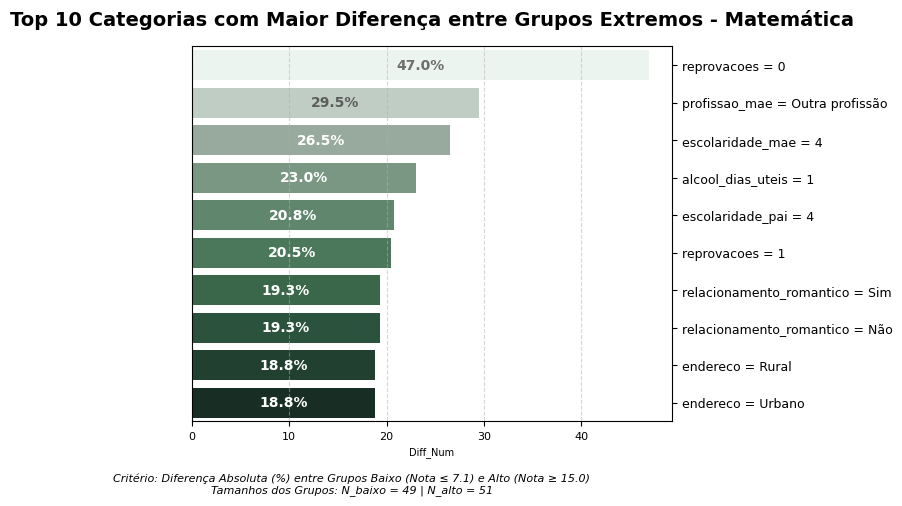

In [98]:
plot_top_diferencas_extremos(
    df_diferencas=df_dif,
    materia=materia,  
    q1_lim=q1_lim,
    q3_lim=q3_lim,
    n_baixo=n_baixo,
    n_alto=n_alto,
    top_n=10,  
    diretorio='graficos_diferencas_perfil',
    salvar=True
)

### 3.5.3 Síntese Analítica dos Destaques

A análise de grupos específicos e casos extremos revelou padrões relevantes para o entendimento do desempenho em Matemática, especialmente em perfis de risco e contrastes entre estudantes com desempenho muito baixo e muito alto.

- **Casos de Nota Zero:** Vinte e seis alunos apresentaram nota final igual a zero, representando 9,42% da amostra. A maioria estava matriculada na escola Gabriel Pereira, residia em área urbana e apresentava características marcantes: 96% não recebiam apoio escolar, 69% não tinham aulas particulares e 85% viviam em famílias com mais de três membros. Curiosamente, 81% dos estudantes com nota zero declararam interesse no ensino superior, apontando para uma desconexão entre aspiração e suporte efetivo.

- **Grupo de Reprovados (Nota Final < 10):** Estudantes reprovados concentraram-se em perfis de menor suporte e exposição a fatores de risco. Mais de 60% não tinham aulas particulares, 81% não recebiam apoio escolar e quase 60% viviam em famílias com baixa escolaridade (nível 1 ou 2). A variável `profissao_pai` foi a mais impactante na variação de desempenho (gap ≈ 4.17), seguida de `frequencia_saidas`, `tempo_transporte` e `alcool_dias_uteis`.

- **Grupo de Aprovados (Nota Final ≥ 10):** Este grupo apresentou melhor perfil familiar e escolar: 54% estudavam ao menos 2h por dia, 97% tinham interesse no ensino superior e 85% tinham acesso à internet. Os pais tendem a ter maior escolaridade (nível 4 ou 5), e há maior equilíbrio nas variáveis relacionadas ao tempo e à organização da rotina.

- **Grupos Extremos (Nota Final ≤ 7.1 vs. ≥ 15.0):** A comparação entre os extremos da distribuição revelou os atributos mais discriminativos:
  - `reprovacoes` apresentou a maior diferença entre os grupos (47 p.p.);
  - `profissao_mae`, `escolaridade_mae` e `alcool_dias_uteis` também superaram 23 p.p. de diferença entre os extremos;
  - Aspectos como `endereco`, `tamanho_familia`, `relacionamento_romantico` e `frequencia_saidas` complementam o conjunto de atributos com grande contraste.

Essas evidências reforçam a importância da integração entre fatores escolares, familiares e individuais para compreender o desempenho extremo — seja em situação de fracasso escolar ou de alta performance.

**Avaliação do impacto de atributos dentro de cada grupo revelou:**
- Para os reprovados, as variáveis com maior impacto sobre `nota_final` foram: `profissao_pai`, `frequencia_saidas`, `alcool_dias_uteis`, `tempo_transporte` e `relacao_familiar`.
- Entre os aprovados, os maiores gaps estiveram associados a: `escolaridade_pai`, `escolaridade_mae`, `profissao_mae`, `alcool_fim_semana` e `tempo_livre`, com variações moderadas e maior equilíbrio nos perfis.



- **Avaliação do impacto de atributos dentro de cada grupo** revelou:
  - Para os reprovados, as variáveis com maior impacto sobre `nota_final` foram: `profissao_mae`, `relacao_familiar`, `frequencia_saidas`, `alcool_dias_uteis` e `tempo_estudo`.
  - Entre os aprovados, as maiores diferenças estiveram associadas a `escolaridade_mae`, `profissao_mae`, `tempo_transporte` e `relacao_familiar`, ainda que com variações mais moderadas.


## 3.6 Distribuição das Notas por Grupos Categóricos

##### **Nota 1**

[FRACO] genero → equilíbrio: 0.54 | gap: 0.53
[MODERADO] profissao_mae → desequilíbrio: 0.37 | gap: 1.71
[MODERADO] profissao_pai → desequilíbrio: 0.54 | gap: 2.89
[FRACO] motivo_escolha_escola → equilíbrio: 0.35 | gap: 0.90
[MODERADO] apoio_escolar → desequilíbrio: 0.87 | gap: 1.88
[FRACO] apoio_familiar → equilíbrio: 0.63 | gap: 0.50
[FRACO] aulas_particulares → equilíbrio: 0.50 | gap: 0.01
[FRACO] atividades_extracurriculares → equilíbrio: 0.51 | gap: 0.42
[MODERADO] interesse_ensino_superior → desequilíbrio: 0.95 | gap: 2.51
[FRACO] relacionamento_romantico → equilíbrio: 0.67 | gap: 0.44
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.65
[MODERADO] relacao_familiar → desequilíbrio: 0.50 | gap: 1.13
[MODERADO] tempo_livre → desequilíbrio: 0.37 | gap: 1.29
[MODERADO] frequencia_saidas → desequilíbrio: 0.29 | gap: 1.43
[MODERADO] saude → desequilíbrio: 0.36 | gap: 1.09
[MODERADO] tempo_estudo → desequilíbrio: 0.54 | gap: 1.55
[FORTE] tempo_transporte → desequilíbrio: 0.67 | gap: 3

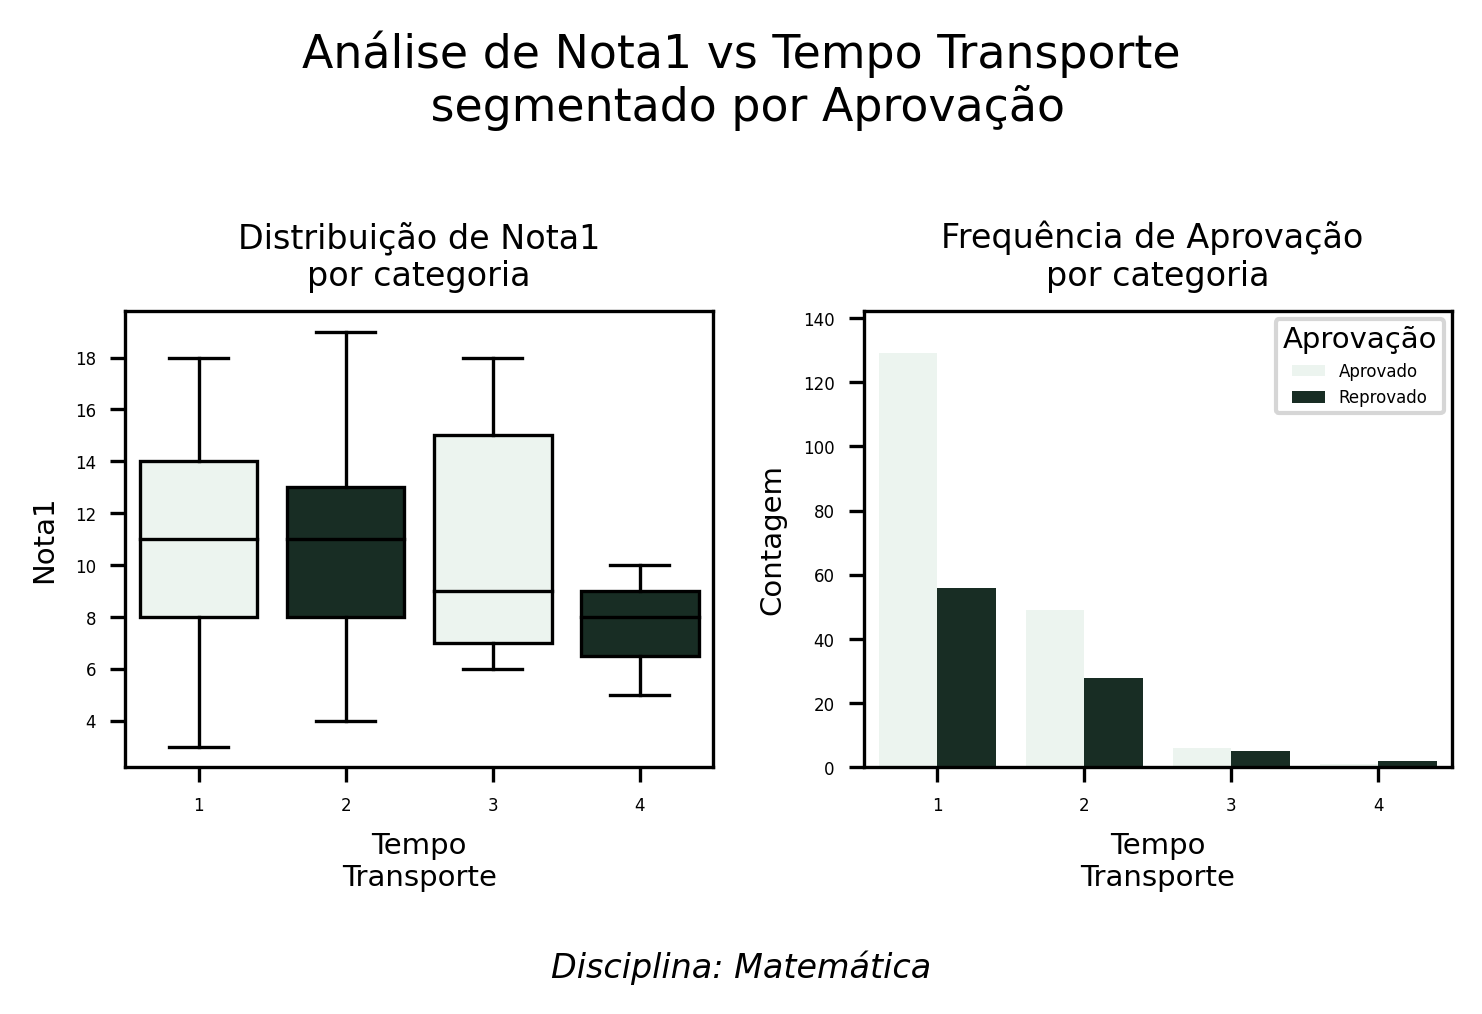

[MODERADO] alcool_dias_uteis → desequilíbrio: 0.71 | gap: 1.82
[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 | gap: 1.58
[FORTE] reprovacoes → desequilíbrio: 0.79 | gap: 4.81
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


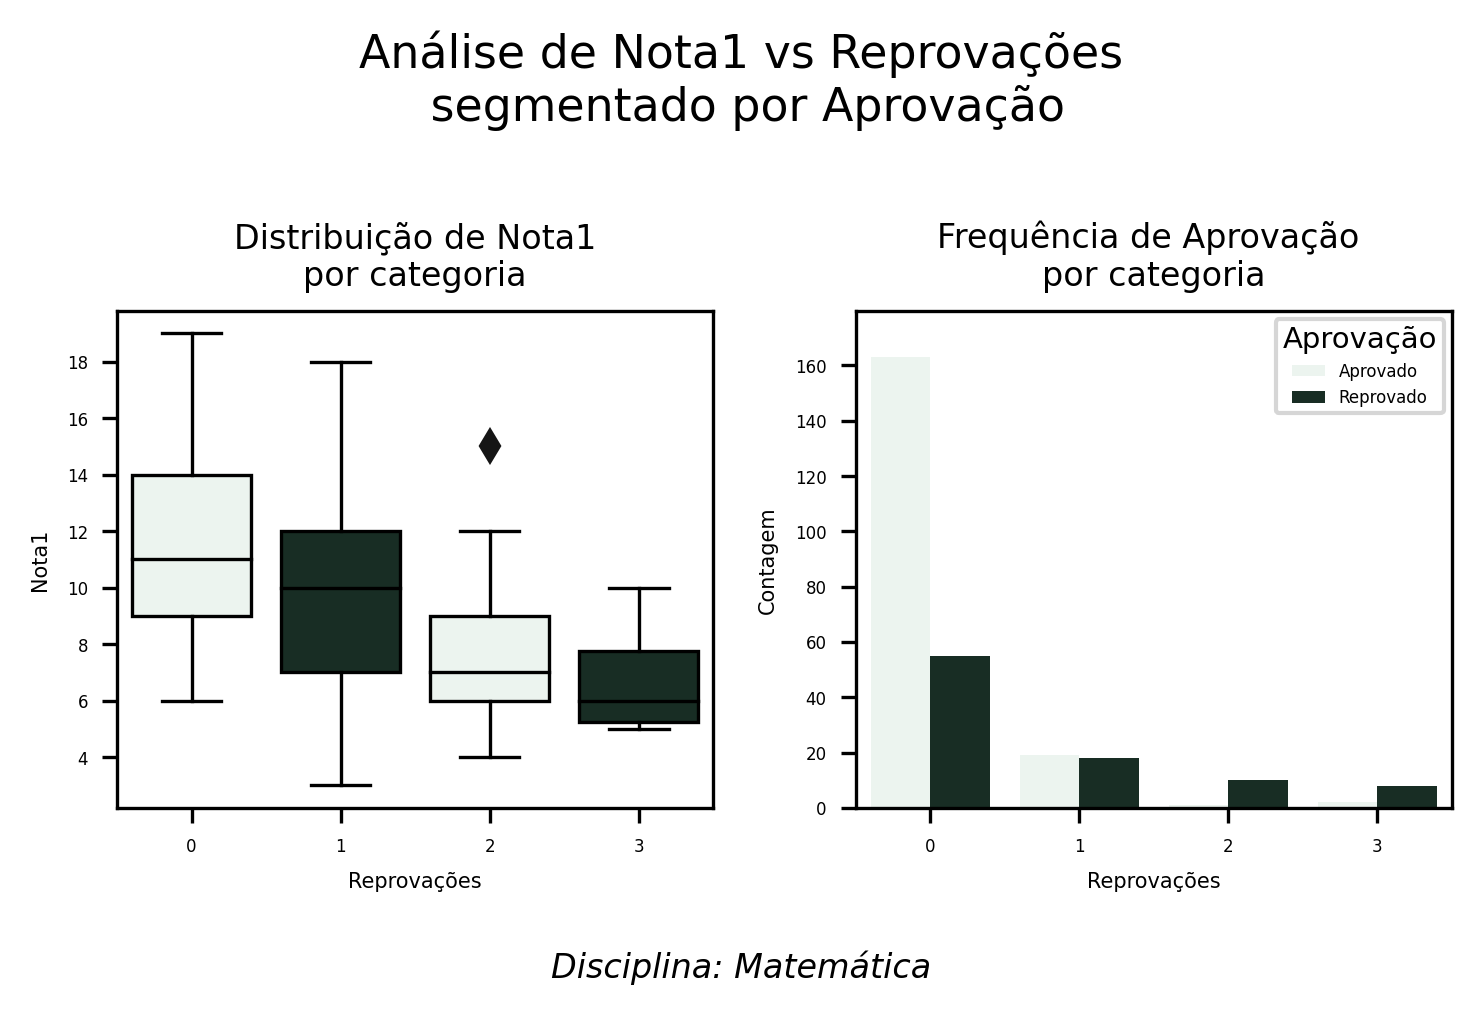

In [99]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='nota1'
                                    )

##### **Nota 2**

[FRACO] genero → equilíbrio: 0.54 | gap: 0.61
[MODERADO] endereco → desequilíbrio: 0.79 | gap: 1.14
[MODERADO] profissao_mae → desequilíbrio: 0.37 | gap: 1.77
[MODERADO] profissao_pai → desequilíbrio: 0.54 | gap: 2.07
[FRACO] motivo_escolha_escola → equilíbrio: 0.35 | gap: 0.79
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.54
[MODERADO] apoio_escolar → desequilíbrio: 0.87 | gap: 1.33
[FRACO] apoio_familiar → equilíbrio: 0.63 | gap: 0.40
[FRACO] aulas_particulares → equilíbrio: 0.50 | gap: 0.44
[FRACO] atividades_extracurriculares → equilíbrio: 0.51 | gap: 0.41
[MODERADO] interesse_ensino_superior → desequilíbrio: 0.95 | gap: 3.29
[FRACO] relacionamento_romantico → equilíbrio: 0.67 | gap: 0.92
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.85
[FRACO] tempo_livre → equilíbrio: 0.37 | gap: 0.79
[MODERADO] frequencia_saidas → desequilíbrio: 0.29 | gap: 1.75
[MODERADO] saude → desequilíbrio: 0.36 | gap: 1.62
[FRACO] tempo_estudo → equilíbrio: 0.54 | gap: 1.03
[MODERADO] t

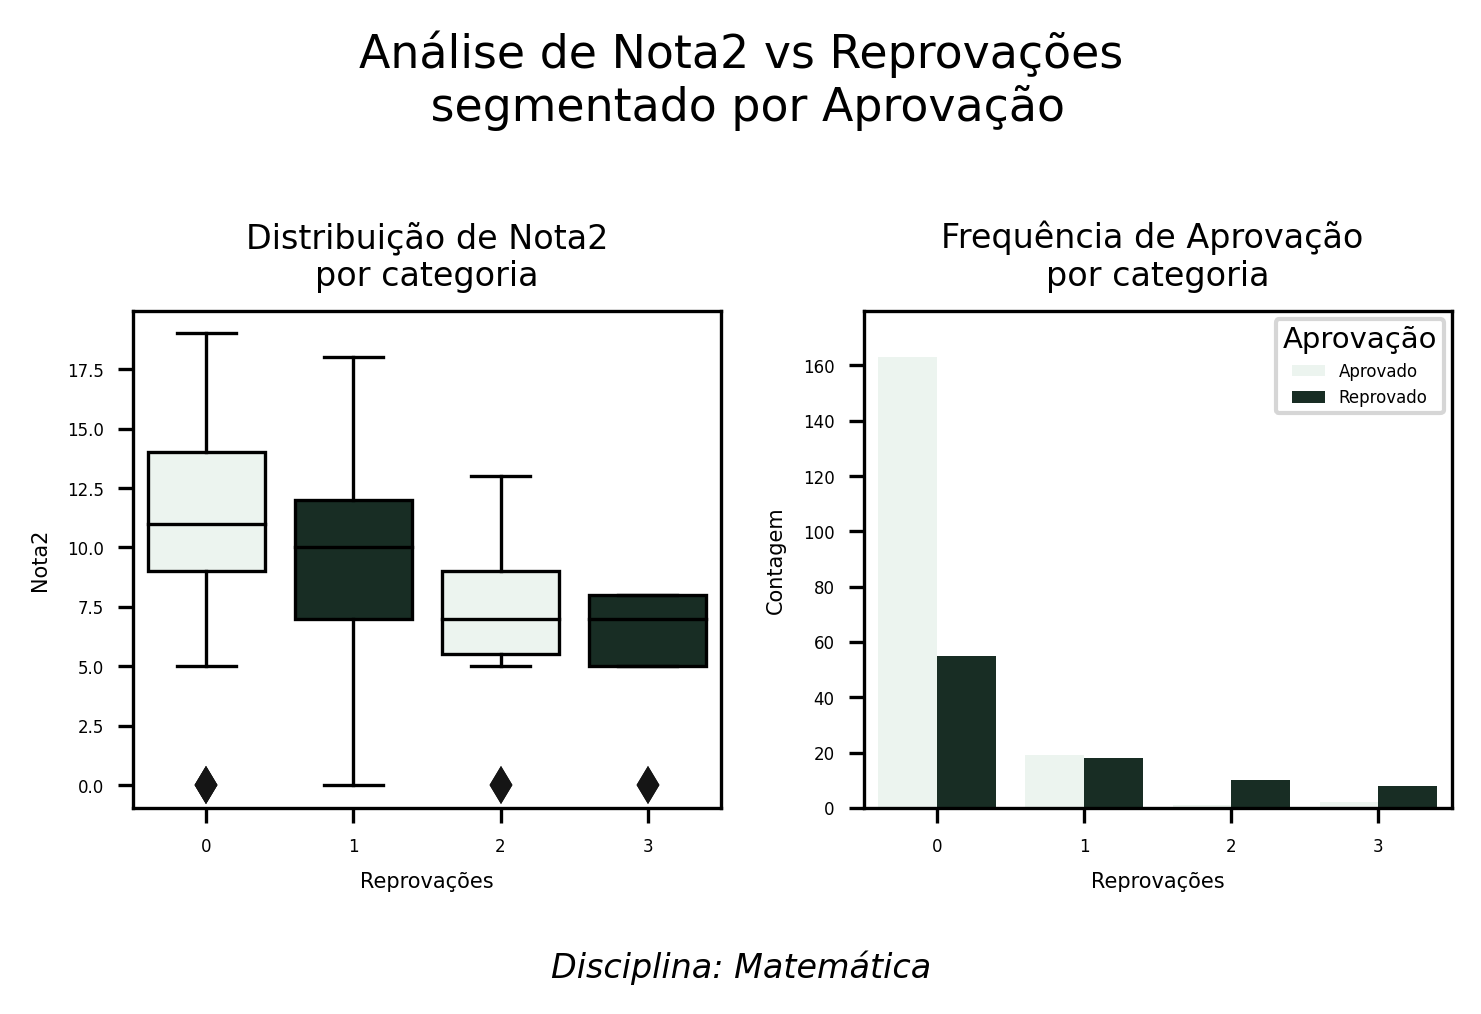

In [100]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='nota2')

##### **Nota Final**

[FRACO] genero → equilíbrio: 0.54 | gap: 0.91
[MODERADO] profissao_mae → desequilíbrio: 0.37 | gap: 1.76
[MODERADO] profissao_pai → desequilíbrio: 0.54 | gap: 2.69
[FRACO] motivo_escolha_escola → equilíbrio: 0.35 | gap: 1.28
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 2.09
[FRACO] apoio_familiar → equilíbrio: 0.63 | gap: 0.61
[FRACO] aulas_particulares → equilíbrio: 0.50 | gap: 0.43
[FRACO] atividades_extracurriculares → equilíbrio: 0.51 | gap: 0.23
[FORTE] interesse_ensino_superior → desequilíbrio: 0.95 | gap: 4.21
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


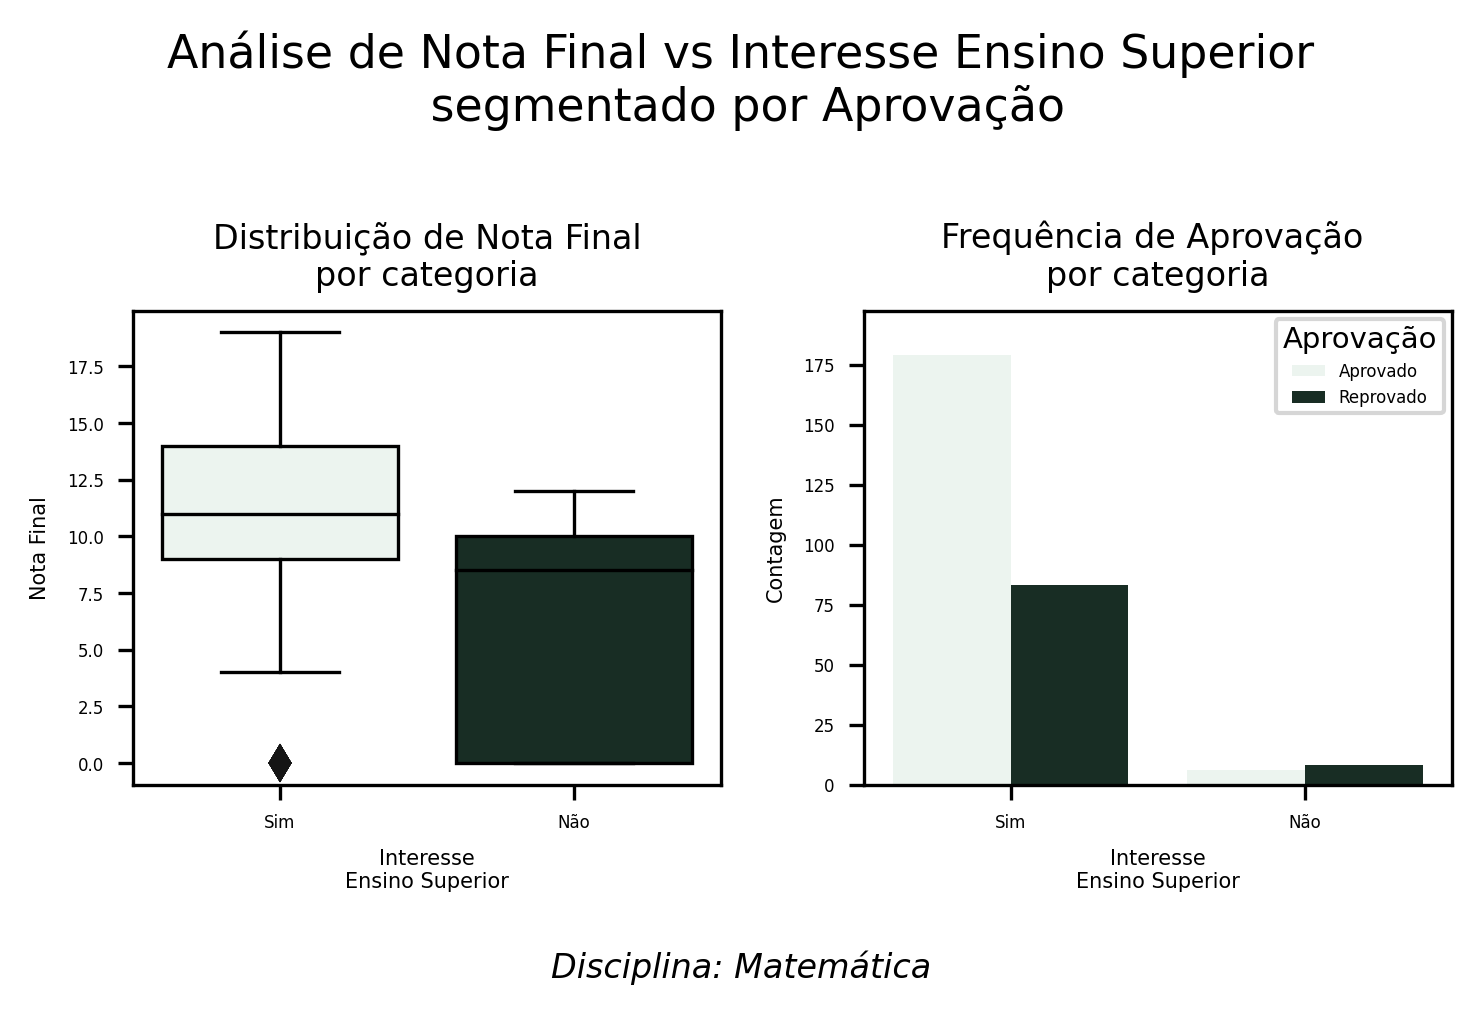

[FRACO] relacionamento_romantico → equilíbrio: 0.67 | gap: 1.21
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 1.18
[MODERADO] relacao_familiar → desequilíbrio: 0.50 | gap: 1.43
[FRACO] tempo_livre → equilíbrio: 0.37 | gap: 0.99
[MODERADO] frequencia_saidas → desequilíbrio: 0.29 | gap: 1.95
[MODERADO] saude → desequilíbrio: 0.36 | gap: 2.22
[FRACO] tempo_estudo → equilíbrio: 0.54 | gap: 0.94
[MODERADO] tempo_transporte → desequilíbrio: 0.67 | gap: 2.10
[MODERADO] alcool_dias_uteis → desequilíbrio: 0.71 | gap: 1.73
[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 | gap: 1.59
[FORTE] reprovacoes → desequilíbrio: 0.79 | gap: 6.61
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


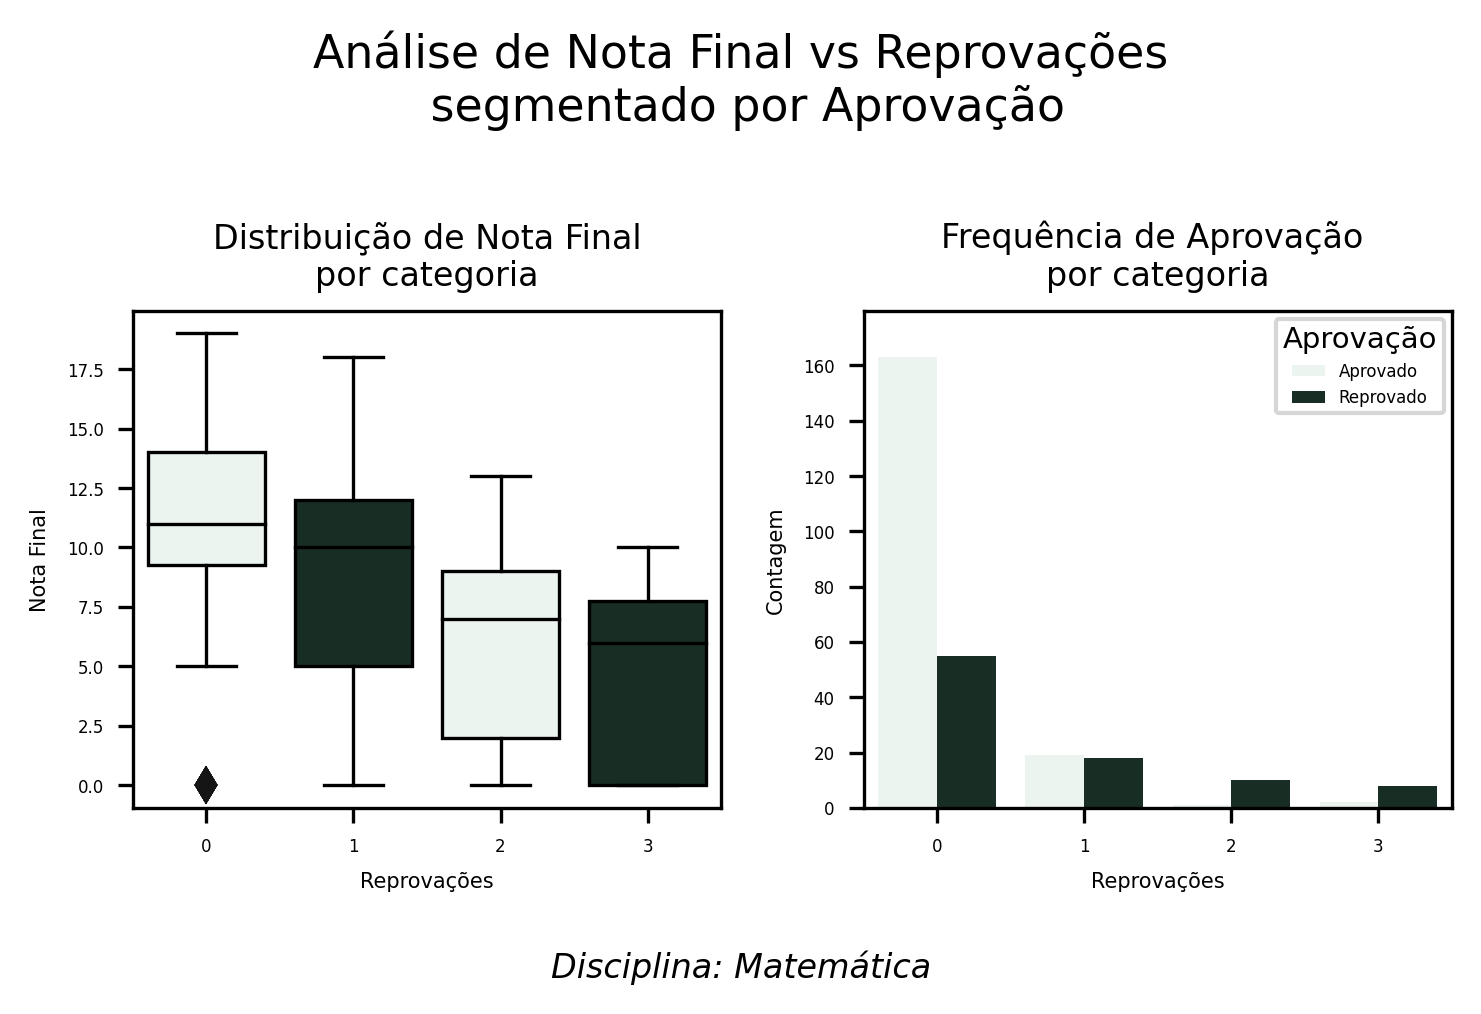

In [101]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='nota_final')

##### **Faltas**

In [102]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='faltas')

[FRACO] genero → equilíbrio: 0.54 | gap: 0.06
[MODERADO] status_parental → desequilíbrio: 0.89 | gap: 5.60
[FRACO] profissao_mae → equilíbrio: 0.37 | gap: 1.56
[MODERADO] motivo_escolha_escola → desequilíbrio: 0.35 | gap: 3.37
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 5.09
[FRACO] apoio_familiar → equilíbrio: 0.63 | gap: 0.20
[FRACO] aulas_particulares → equilíbrio: 0.50 | gap: 0.07
[FRACO] atividades_extracurriculares → equilíbrio: 0.51 | gap: 0.94
[MODERADO] relacionamento_romantico → desequilíbrio: 0.67 | gap: 2.89
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.72
[MODERADO] escolaridade_pai → desequilíbrio: 0.31 | gap: 4.36
[MODERADO] relacao_familiar → desequilíbrio: 0.50 | gap: 4.23
[MODERADO] frequencia_saidas → desequilíbrio: 0.29 | gap: 2.43
[FRACO] saude → equilíbrio: 0.36 | gap: 1.28
[MODERADO] tempo_estudo → desequilíbrio: 0.54 | gap: 3.33
[MODERADO] alcool_dias_uteis → desequilíbrio: 0.71 | gap: 5.94
[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 |

# 4. Análise de Perfis Latentes via PCA e KMeans

Objetivo: Verificar se há perfis de alunos com características semelhantes com base nas variáveis selecionadas, por meio de técnicas de redução de dimensionalidade (PCA) e clusterização (KMeans).

## 4.2 Preparação dos Dados

In [103]:
df_pp = preparar_dados(df_t, columns_to_drop=['aprovacao','nota1','nota2'],target_column='nota_final',scaling=True)

Removendo colunas: ['aprovacao', 'nota1', 'nota2']
Aplicando Imputação(mean) e Scaling(StandardScaler) a: ['idade', 'escolaridade_mae', 'escolaridade_pai', 'tempo_transporte', 'tempo_estudo', 'reprovacoes', 'relacao_familiar', 'tempo_livre', 'frequencia_saidas', 'alcool_dias_uteis', 'alcool_fim_semana', 'saude', 'faltas']
Shape final do DataFrame preparado: (276, 40)


In [104]:
X = df_pp.drop(columns=['nota_final'])
y = df_pp['nota_final']


## 4.3 Aplicação do PCA

In [105]:

# Seleção dos dados 

pca = PCA()
X_pca = pca.fit_transform(X)


## 4.4 Clusterização com KMeans

### Definindo o número de clusters

In [106]:
from sklearn.metrics import silhouette_score

In [107]:
k_values = list(range(2, 9))
inercia = []
silhouette = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inercia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))

# Cálculo da redução percentual da inércia
reducoes = np.diff(inercia) / inercia[:-1]
limiar = 0.15 #redução mínima esperada

# Determina melhor k pelo método do cotovelo
melhor_k_cotovelo = None
for k_idx, r in enumerate(reducoes, start=2):
    if abs(r) * 100 < limiar * 100 and melhor_k_cotovelo is None:
        melhor_k_cotovelo = k_idx
if melhor_k_cotovelo is None:
    melhor_k_cotovelo = k_values[-1]

# Melhor k pelo índice de silhueta
melhor_k_silhueta = k_values[np.argmax(silhouette)]


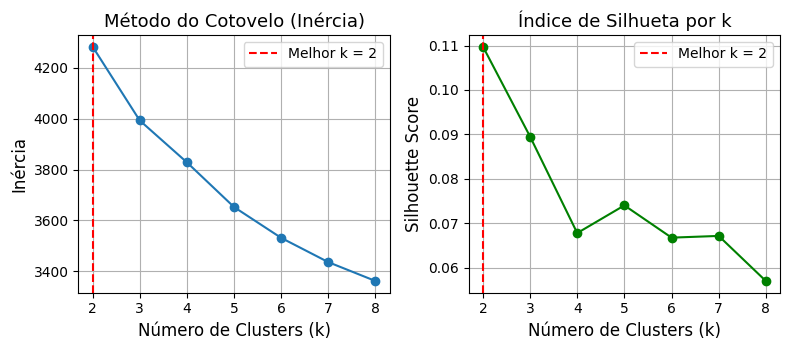

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.6))

# Tamanho da fonte
fs_ticks = 10
fs_labels = 12
fs_title = 13

# Cotovelo
axs[0].plot(k_values, inercia, marker='o')
axs[0].axvline(x=melhor_k_cotovelo, color='red', linestyle='--', label=f'Melhor k = {melhor_k_cotovelo}')
axs[0].set_title('Método do Cotovelo (Inércia)', fontsize=fs_title)
axs[0].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[0].set_ylabel('Inércia', fontsize=fs_labels)
axs[0].legend(fontsize=fs_ticks)
axs[0].set_xticks(k_values)
axs[0].tick_params(axis='both', labelsize=fs_ticks)
axs[0].grid(True)

# Silhueta
axs[1].plot(k_values, silhouette, marker='o', color='green')
axs[1].axvline(x=melhor_k_silhueta, color='red', linestyle='--', label=f'Melhor k = {melhor_k_silhueta}')
axs[1].set_title('Índice de Silhueta por k', fontsize=fs_title)
axs[1].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[1].set_ylabel('Silhouette Score', fontsize=fs_labels)
axs[1].legend(fontsize=fs_ticks)
axs[1].set_xticks(k_values)
axs[1].tick_params(axis='both', labelsize=fs_ticks)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [109]:
# PCA (Análise de Componentes Principais)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [110]:
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


#### Influência de Variáveis sobre o PCA

In [111]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['Componente 1', 'Componente 2'],
    index=X.columns)

loadings['Magnitude'] = loadings.apply(lambda x: np.sqrt(x['Componente 1']**2 + x['Componente 2']**2), axis=1)
loadings = loadings.sort_values(by='Magnitude', ascending=False)
loadings = loadings[loadings['Magnitude'] > 0.1]        
loadings = loadings.reset_index()
loadings.columns = ['Variável', 'Componente 1', 'Componente 2', 'Magnitude']
loadings

,Variável,Componente 1,Componente 2,Magnitude
0,escolaridade_mae,-0.136906,0.565137,0.581483
1,escolaridade_pai,-0.162659,0.548832,0.572429
2,alcool_fim_semana,0.490915,0.179400,0.522668
3,alcool_dias_uteis,0.460457,0.213511,0.507550
4,frequencia_saidas,0.350265,0.186550,0.396845
5,reprovacoes,0.316351,-0.213745,0.381792
6,idade,0.263981,-0.204776,0.334094
7,tempo_livre,0.231650,0.187409,0.297966
8,tempo_transporte,0.143602,-0.246570,0.285339
9,tempo_estudo,-0.254268,-0.105741,0.275379


### Interpretação do Componente Principal 1 (PC1) – Matemática

O primeiro componente principal representa um eixo de **comportamento de risco escolar e menor estrutura familiar**. Estudantes com **valores mais altos em PC1** tendem a:

- Ter maior consumo de álcool (durante a semana e no fim de semana);
- Sair com maior frequência;
- Ter mais reprovações anteriores;
- Estar em faixas etárias mais elevadas.

Já os com **valores mais baixos em PC1** tendem a:

- Estudar mais;
- Ter pais mais escolarizados.

Esse componente separa os alunos entre perfis mais vulneráveis do ponto de vista comportamental e acadêmico e perfis mais disciplinados e favorecidos pelo ambiente familiar.

---

### Interpretação do Componente Principal 2 (PC2) – Matemática

O segundo componente principal reflete um eixo de **capital educacional e condições favoráveis ao estudo**. Alunos com **valores mais altos em PC2** tendem a ter:

- Pais mais escolarizados (especialmente a mãe);
- Menor número de reprovações;
- Menor idade;
- Menor tempo de transporte até a escola.

Já valores baixos no PC2 podem indicar **barreiras estruturais e histórico escolar mais fragilizado**, mesmo sem a presença de comportamentos de risco evidentes.


In [112]:
cores = aplicar_estilo_visual(paleta=cores,n =10)[::-1]

In [113]:
top_loadings = loadings.head(10)


### **Atributos mais influenciaram a estrutura de agrupamento no PCA**

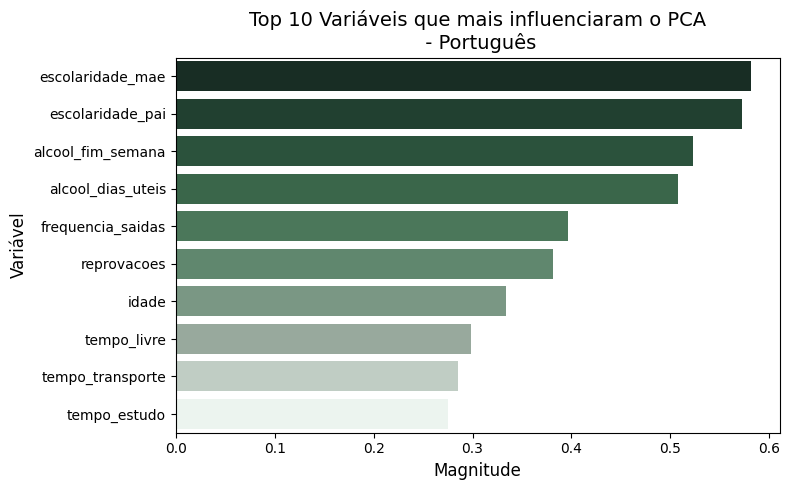

In [114]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Magnitude', y='Variável', data=top_loadings, palette=cores)

plt.title('Top 10 Variáveis que mais influenciaram o PCA\n - Português', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Variável', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


>PC1: alto peso para alcool_dias_uteis, alcool_fim_semana, frequencia_saidas (indicadores de comportamento social), além de reprovacoes e idade.
Cargas negativas para tempo_estudo, escolaridade_pai e escolaridade_mae, indicando que valores baixos em PC1 estão associados a maior engajamento e capital educacional familiar.

>PC2: forte contribuição positiva de escolaridade_mae e escolaridade_pai (indicadores de capital educacional), com cargas negativas para tempo_transporte, reprovacoes e idade.
>Esse componente distingue estudantes com melhores condições familiares e estruturais de estudo daqueles em contextos potencialmente mais limitantes.

#### **k=2**

In [115]:
df['cluster_k2'] = KMeans(n_clusters=melhor_k_cotovelo, random_state=42).fit_predict(X_pca)

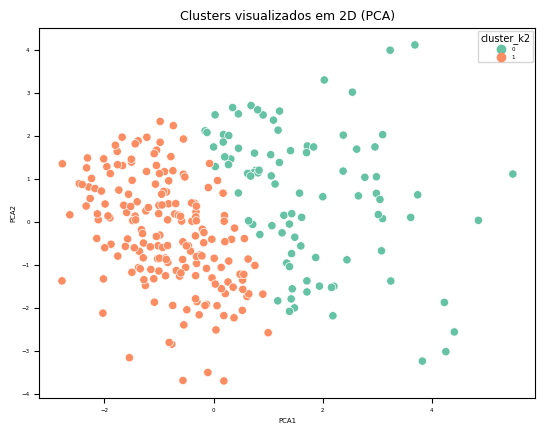

In [116]:
df['cluster_k2'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# 5. Visualiza os clusters  
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k2', data=df, palette='Set2')
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()


## 4.6 Análise dos Clusters

In [117]:
pca.explained_variance_ratio_

array([0.13981053, 0.12193373])

> A análise conjunta dos dois primeiros componentes principais explica cerca de **26,17% da variância total** dos dados. O PC1 representa um eixo de risco acadêmico e comportamental, enquanto o PC2 reflete o capital educacional e barreiras estruturais dos estudantes. A visualização dos clusters no espaço PCA 2D evidencia a separação entre dois grupos latentes de alunos, com perfis distintos em termos de desempenho e contexto escolar.


### **Detalhamento dos Perfis**

In [118]:
add_features_describe_pd(df[df['cluster_k2']==0], estudo_frequencia=True, colunas=variaveis_categoricas)

Tamanho da amostra (categórico): 92


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,77,83.695652,2.173913
genero,2,Homem,67,72.826087,2.173913
endereco,2,Urbano,68,73.913043,2.173913
status_parental,2,Juntos,84,91.304348,2.173913
profissao_mae,5,Outra profissão,32,34.782609,5.434783
profissao_pai,5,Outra profissão,50,54.347826,5.434783
motivo_escolha_escola,4,Curso específico,34,36.956522,4.347826
responsavel_legal,3,Mãe,61,66.304348,3.26087
apoio_escolar,2,Não,81,88.043478,2.173913


> ### Perfil dominante no Cluster 0 (valores mais altos em PC1 e mais baixos em PC2)  
>  
> A análise das variáveis categóricas dominantes no `cluster_k2 = 0`, que corresponde aos estudantes com valores mais **altos em PC1** e **mais baixos em PC2**, reforça a interpretação de maior vulnerabilidade escolar. Os estudantes desse grupo apresentam:  
>  
> - Maior proporção de homens;  
> - Menor escolaridade dos pais;  
> - Menor tempo de estudo e maior frequência de reprovações;  
> - Maior consumo de álcool durante a semana e aos finais de semana;  
> - Menor presença de suporte escolar e menor participação em aulas particulares.  
>  
> Esses padrões são consistentes com o perfil de estudantes **mais expostos a comportamentos de risco acadêmico e social**, com **menor capital educacional familiar** e **barreiras estruturais mais intensas**, como maior tempo de transporte e apoio limitado ao aprendizado.



In [119]:
add_features_describe_pd(df[df['cluster_k2']==1], estudo_frequencia=True, colunas=variaveis_categoricas)

Tamanho da amostra (categórico): 184


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,168,91.304348,1.086957
genero,2,Mulher,123,66.847826,1.086957
endereco,2,Urbano,150,81.521739,1.086957
status_parental,2,Juntos,162,88.043478,1.086957
profissao_mae,5,Outra profissão,69,37.5,2.717391
profissao_pai,5,Outra profissão,99,53.804348,2.717391
motivo_escolha_escola,4,Curso específico,62,33.695652,2.173913
responsavel_legal,3,Mãe,134,72.826087,1.630435
apoio_escolar,2,Não,159,86.413043,1.086957


> ### Perfil dominante no Cluster 1 (valores mais baixos em PC1 e mais altos em PC2)  
>  
> O `cluster_k2 = 1`, correspondente aos estudantes com **valores mais baixos em PC1** e **mais altos em PC2**, apresenta um perfil mais estruturado e academicamente favorecido. Os estudantes desse grupo se caracterizam por:  
>  
> - Maior proporção de mulheres;  
> - Maior escolaridade dos pais e maior intenção de cursar o ensino superior;  
> - Menor consumo de álcool, especialmente durante a semana;  
> - Maior tempo de estudo e menor número de reprovações;  
> - Predominância de estudantes que residem em área urbana e frequentaram creche;  
> - Maior participação em aulas particulares e melhor estrutura familiar.  
>  
> Essas características indicam um **perfil mais disciplinado, com condições socioeducacionais mais favoráveis ao desempenho acadêmico**, reafirmando o papel do PC1 como eixo de engajamento escolar e do PC2 como indicador de capital educacional e estrutura familiar.


In [120]:
df[['idade','cluster_k2']].value_counts().reset_index()

,idade,cluster_k2,0
0,16,1,56
1,15,1,47
2,17,1,38
3,18,1,35
4,17,0,33
5,18,0,19
6,16,0,18
7,15,0,10
8,19,0,10
9,19,1,8


> ### Idade e perfis dos clusters — Matemática  
>  
> A distribuição da idade entre os clusters evidencia uma diferença importante no perfil acadêmico dos estudantes.  
>  
> - O `cluster_k2 = 1` (valores mais baixos em PC1 e mais altos em PC2), associado ao perfil mais estruturado, concentra a maior parte dos estudantes com **15 e 16 anos**, faixa etária esperada para as séries do ensino médio.  
>  
> - Já o `cluster_k2 = 0` (valores mais altos em PC1 e mais baixos em PC2), vinculado a comportamentos de risco e menor suporte escolar, apresenta maior proporção de **alunos mais velhos** (17 a 21 anos), o que indica **possível atraso escolar** decorrente de reprovações anteriores.  
>  
> Esses dados reforçam as interpretações feitas com base no PCA, mostrando que os componentes principais e os agrupamentos obtidos refletem **diferenças reais no histórico escolar e contexto educacional dos estudantes**.



### **Desempenho**

In [121]:
df.groupby('cluster_k2')[['nota1','nota2','nota_final','faltas']].agg(['mean', 'std', 'count'])



nota1                      nota2                 nota_final  \
                 mean       std count       mean       std count       mean   
cluster_k2                                                                    
0           10.141304  3.260087    92   9.804348  3.527721    92   9.336957   
1           11.250000  3.293063   184  11.244565  3.716743   184  10.972826   

                              faltas                  
                 std count      mean       std count  
cluster_k2                                            
0           4.279461    92  7.967391  7.887187    92  
1           4.633487   184  4.733696  7.585560   184

In [122]:
pd.crosstab(df['cluster_k2'], df['aprovacao'], normalize='index') * 100


aprovacao,Aprovado,Reprovado
cluster_k2,,
0,54.347826,45.652174
1,73.369565,26.630435


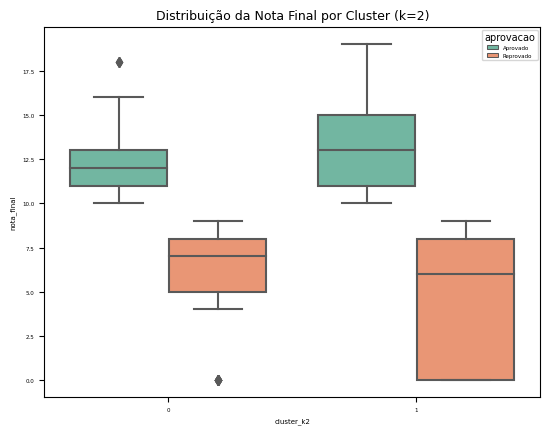

In [123]:

# Gráfico de dispersão
sns.boxplot(data=df, x='cluster_k2', y='nota_final', hue='aprovacao',palette='Set2')
plt.title('Distribuição da Nota Final por Cluster (k=2)')
plt.show()


> ### Desempenho acadêmico e presença em sala por cluster — Matemática  
>  
> A média das notas (nota1, nota2 e nota final), as faltas e a taxa de aprovação confirmam diferenças claras entre os dois grupos identificados pelo PCA + KMeans:
>  
> - **Cluster 1** (valores mais baixos em PC1 e mais altos em PC2):  
>     - Nota final média: **10,97**  
>     - Faltas médias: **4,73**  
>     - Taxa de aprovação: **73,4%**
>  
> - **Cluster 0** (valores mais altos em PC1 e mais baixos em PC2):  
>     - Nota final média: **9,34**  
>     - Faltas médias: **7,97**  
>     - Taxa de aprovação: **54,3%**
>  
> O gráfico reforça que os estudantes do **cluster 1** apresentam desempenho acadêmico superior, menor dispersão negativa e menor evasão. Já o **cluster 0** concentra maior quantidade de faltas, menor média de notas e uma proporção mais elevada de reprovação.  
>  
> Esses achados confirmam que os agrupamentos gerados refletem **diferenças reais nos padrões de desempenho e comprometimento escolar**, fortalecendo a validade da segmentação obtida com base nos componentes principais.

>  

## 4.7 Conclusão da Análise de Perfis (PCA + KMeans)

> ### Conclusão da Análise Multivariada com PCA + KMeans  
>  
> A aplicação combinada de Análise de Componentes Principais (PCA) e KMeans permitiu identificar **perfis latentes de estudantes** com base em múltiplas dimensões relacionadas a comportamento, contexto familiar e histórico acadêmico.
>  
> Em ambas as disciplinas (Português e Matemática), os dois primeiros componentes principais explicaram cerca de **25% da variância total**, sendo suficientes para discriminar dois grupos distintos de estudantes.
>  
> - O **Componente 1 (PC1)**, em ambos os casos, refletiu um eixo de **risco acadêmico e comportamental**, com pesos elevados para consumo de álcool, frequência de saídas e reprovações, e cargas negativas para tempo de estudo e escolaridade dos pais.
> - O **Componente 2 (PC2)** representou um eixo de **capital educacional familiar e barreiras logísticas**, diferenciando alunos com pais mais escolarizados, menor idade e menor tempo de transporte daqueles com contextos mais adversos.
>  
> A clusterização (k=2) sobre os componentes revelou grupos com **diferenças concretas de desempenho escolar, frequência e idade**, refletindo os eixos latentes identificados pelo PCA.
>  

In [124]:
df_t.genero.value_counts(normalize=True)

Mulher    0.536232
Homem     0.463768
Name: genero, dtype: float64

## 5. SELEÇÃO DE VARIÁVEIS PARA MODELAGEM (Baseada na EDA)

A Análise Exploratória de Dados (EDA) sobre a disciplina de Matemática possibilitou a construção de um conjunto inicial de variáveis candidatas à modelagem preditiva da **aprovação binária**. Foram adotados critérios integrados de seleção baseados em:

- **Impacto estatístico** (gap entre categorias e desequilíbrio);
- **Índice de Perfil Composto** (entropia × variação de notas);
- **Diferença entre grupos extremos** (nota_final ≤ 7,1 vs ≥ 15,0);
- **Associação com outliers e casos críticos** (nota_final = 0, faltas > 20);
- **Relevância conceitual e ausência de redundância**.

### 5.1 Exclusão de Variáveis Diretas de Desempenho

Foram excluídas as variáveis diretamente associadas às notas (`nota1`, `nota2`, `nota_final`), por risco de vazamento de alvo (*target leakage*) e pela intenção de modelar a aprovação com base em **fatores antecedentes e contextuais**.

---

### 5.2 Variáveis Quantitativas Selecionadas

- **`faltas`**  
  Associada negativamente à aprovação, com presença marcante entre alunos com nota zero e forte impacto nas análises de perfil e outliers.

- **`idade`**  
  Manteve independência em relação às demais variáveis, com utilidade como proxy para defasagem ou transição entre séries.

---

### 5.3 Variáveis Categóricas com Forte Discriminância

- **`reprovacoes`**  
  Variável de maior impacto (gap de até 47 p.p.). Mantida mesmo com desequilíbrio por seu alto poder explicativo.

- **`tempo_estudo`**  
  Associada diretamente a desempenho e aprovação. Selecionada por sua simplicidade e relação clara com a dedicação acadêmica.

- **`interesse_ensino_superior`**  
  Fortemente correlacionada a notas altas, tanto na média quanto nos extremos.

- **`escolaridade_mae`**  
  Mantida no lugar de `escolaridade_pai`, por apresentar maior variação, entropia e impacto mais consistente.

---

### 5.4 Variáveis Mantidas por Valor Complementar

- **`alcool_dias_uteis`**  
  Selecionada em detrimento de `alcool_fim_semana`, por apresentar maior correlação com desempenho e menor sobreposição com `frequencia_saidas`.

- **`frequencia_saidas`**  
  Indicador comportamental relevante, com impacto visível nos grupos de baixo desempenho.

- **`tempo_transporte`**  
  Retida por seu efeito negativo sobre tempo de estudo e associação com casos de nota zero.

- **`relacao_familiar`**  
  Reflete o ambiente socioafetivo do aluno, com variações relevantes entre aprovados e reprovados.

- **`responsavel_legal`**  
  Embora mais sutil, contribui para capturar a configuração familiar em conjunto com outras variáveis.

---

### 5.5 Variáveis Excluídas por Sobreposição ou Baixo Impacto

- **`alcool_fim_semana`** — Excluída por redundância com `alcool_dias_uteis`.
- **`escolaridade_pai`** — Substituída por `escolaridade_mae` com melhor desempenho explicativo.
- **`profissao_mae`** e **`profissao_pai`** — Apesar de impacto em casos extremos, foram consideradas menos generalizáveis.
- **`motivo_escolha_escola`**, **`status_parental`**, **`tamanho_familia`** — Excluídas por baixa diversidade, equilíbrio ou efeito limitado nas análises.

---

### 5.6 Conjunto Final Selecionado (13 variáveis)

| Tipo         | Variável                    | Justificativa resumida                                       |
|--------------|-----------------------------|---------------------------------------------------------------|
| Quantitativa | `faltas`                    | Indicador direto de envolvimento escolar                      |
| Quantitativa | `idade`                     | Relacionada à defasagem e histórico escolar                   |
| Categórica   | `reprovacoes`               | Variável mais discriminante da base                           |
| Categórica   | `tempo_estudo`              | Forte relação com aprovação e foco acadêmico                  |
| Categórica   | `interesse_ensino_superior` | Alta motivação e valor explicativo                            |
| Categórica   | `escolaridade_mae`          | Proxy de capital educacional                                  |
| Categórica   | `alcool_dias_uteis`         | Risco comportamental com maior impacto que fim de semana      |
| Categórica   | `frequencia_saidas`         | Comportamento social com relação ao desempenho                |
| Categórica   | `tempo_transporte`          | Redutor de tempo de estudo, associado a notas baixas          |
| Categórica   | `relacao_familiar`          | Indicador emocional e de suporte doméstico                    |
| Categórica   | `responsavel_legal`         | Complementa padrão familiar e vínculo de cuidado              |
| Categórica   | `apoio_escolar`             | Associada a padrões de dificuldade escolar                    |
| Categórica   | `acesso_internet`           | Relevante para infraestrutura de aprendizagem                 |

---

### 5.7 Próximos Passos

O conjunto final será submetido às seguintes etapas:

- Codificação adequada (One-Hot e Ordinal);
- Verificação de multicolinearidade;
- Validação cruzada estratificada;
- Avaliação da importância dos atributos;
- Teste de exclusões marginais e combinação de atributos;
- Aplicação em diferentes algoritmos de classificação.


In [125]:
# Variáveis que serão utilizadas para a seleção de atributos
# na modelagem com base na EDA
selecao_baseada_em_eda_mat = [
    "faltas", "idade",
    "reprovacoes", "tempo_estudo", "interesse_ensino_superior",
    "escolaridade_mae", "alcool_dias_uteis", "frequencia_saidas",
    "tempo_transporte", "relacao_familiar", "responsavel_legal",
    "apoio_escolar", "acesso_internet"
]
